# **Case Técnico – Cientista de Dados Júnior | Datarisk (Análise Exploratória -> EDA)**

No segundo notebook, aprofunda-se a compreensão das bases por meio de uma análise exploratória estruturada, com o objetivo de identificar padrões relevantes, comportamentos de risco e potenciais sinais de vazamento de informação.

A EDA está organizada em blocos que abordam diferentes perspectivas:


* **Construção da variável alvo:**
  A partir da regra proposta para a elaboração de um cliente inadimplente e adimplente, constroi-se o target que será avaliado durante o caso.

* **Análise univariada:**
  Explora-se a distribuição das variáveis numéricas e categóricas, avaliando assimetrias, outliers e predominância de categorias, além de mapear possíveis variáveis com baixa variabilidade.

* **Análise Multivariada:**
  São analisados indicadores proxy de atraso para identificar variáveis com impacto potencial no risco.

# 1. Importação das bibliotecas

- pandas: Manipulação dos dados
- numpy: Manipulação numérica
- DataUtils: Classe criada para abstrair boiler plates
- matplotlib e seaborn: Visualização dos dados
- sklearn: Separação em treino e teste

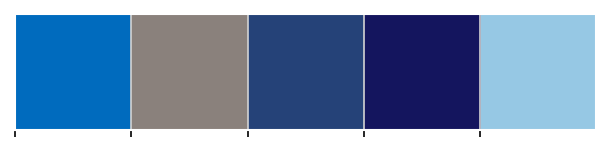

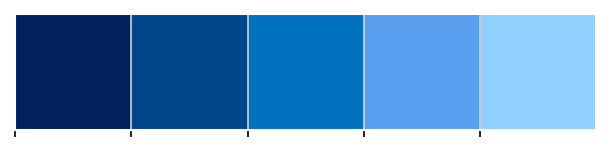

In [2]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from src.eda_utils import *


pd.set_option('display.max_rows', None)
pd.set_option('display.max_info_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.2f}'.format)


import warnings
warnings.filterwarnings('ignore')

# Configurações de visualização
mpl.style.use('ggplot')
mpl.rcParams['axes.facecolor']      = 'white'
mpl.rcParams['grid.color']          = 'lightgray'
mpl.rcParams['xtick.color']         = 'black'
mpl.rcParams['ytick.color']         = 'black'
mpl.rcParams['axes.grid']           = True
mpl.rcParams['figure.dpi']          = 150

# Palette
instyle_palette = ['#006bbe', '#8a817c', '#254278', "#14155E", '#96c8e4']
progress_palette = ['#00215d', '#00468b', '#0071bc', '#589fef', '#8fd0ff']


sns.set_palette(sns.color_palette(instyle_palette))
sns.palplot(sns.color_palette(instyle_palette))
sns.palplot(sns.color_palette(progress_palette))


### **2. Construção do target**

Para este desafio, definiu-se que um cliente deve ser considerado inadimplente quando o pagamento ocorrer com 5 dias ou mais de atraso em relação à data de vencimento. Como essa classificação não está presente no dataset, o target deve ser construído a partir das variáveis disponíveis.

Assim, adotaremos a seguinte regra:

- TARGET = 1 → quando DATA_PAGAMENTO - DATA_VENCIMENTO ≥ 5
- TARGET = 0 → caso contrário



In [3]:
base_pag = DataUtils.read_data(file='base_pagamentos_desenvolvimento.xlsx', processed=True ,file_type='xlsx')

base_pag.head()

..\data\processed\base_pagamentos_desenvolvimento.xlsx


,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_PAGAMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA
0,1661240395903230976,2018-08-01,2018-08-17,2018-09-06,2018-09-06,35516.41,6.99
1,1661240395903230976,2018-08-01,2018-08-19,2018-09-11,2018-09-10,17758.21,6.99
2,1661240395903230976,2018-08-01,2018-08-26,2018-09-18,2018-09-17,17431.96,6.99
3,1661240395903230976,2018-08-01,2018-08-30,2018-10-11,2018-10-05,1341.00,6.99
4,1661240395903230976,2018-08-01,2018-08-31,2018-09-20,2018-09-20,21309.85,6.99


O primeiro passo passo para a construção é a comparação entre os dias de atraso, dessa forma, utilizaremos as colunas DATA_PAGAMENTO e DATA_VENCIMENTO para compor esta nova coluna.

In [4]:
base_pag['DIAS_ATRASO'] = (base_pag['DATA_PAGAMENTO'] - base_pag['DATA_VENCIMENTO']).dt.days


base_pag.head()

,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_PAGAMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA,DIAS_ATRASO
0,1661240395903230976,2018-08-01,2018-08-17,2018-09-06,2018-09-06,35516.41,6.99,0
1,1661240395903230976,2018-08-01,2018-08-19,2018-09-11,2018-09-10,17758.21,6.99,1
2,1661240395903230976,2018-08-01,2018-08-26,2018-09-18,2018-09-17,17431.96,6.99,1
3,1661240395903230976,2018-08-01,2018-08-30,2018-10-11,2018-10-05,1341.00,6.99,6
4,1661240395903230976,2018-08-01,2018-08-31,2018-09-20,2018-09-20,21309.85,6.99,0


Com os dias de atraso definidos, podemos então, construir o **target** a partir da regra proposta.

In [5]:
base_pag['INADIMPLENTE'] = np.where(base_pag['DIAS_ATRASO'] >= 5, 1, 0)

base_pag.head()

,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_PAGAMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA,DIAS_ATRASO,INADIMPLENTE
0,1661240395903230976,2018-08-01,2018-08-17,2018-09-06,2018-09-06,35516.41,6.99,0,0
1,1661240395903230976,2018-08-01,2018-08-19,2018-09-11,2018-09-10,17758.21,6.99,1,0
2,1661240395903230976,2018-08-01,2018-08-26,2018-09-18,2018-09-17,17431.96,6.99,1,0
3,1661240395903230976,2018-08-01,2018-08-30,2018-10-11,2018-10-05,1341.00,6.99,6,1
4,1661240395903230976,2018-08-01,2018-08-31,2018-09-20,2018-09-20,21309.85,6.99,0,0


### **3. Separação entre treino e teste (dados de validação)**

Após a construção correta da variável target, podemos avançar para a análise exploratória e posteriormente para a modelagem. No entanto, como o objetivo do projeto é prever a probabilidade de inadimplência **em períodos futuros**, é essencial que a avaliação do modelo respeite a dimensão temporal dos dados.

Por esse motivo, a separação entre dados de treino e teste será feita utilizando a estratégia Out-of-Time split (OOT).
Diferentemente de um train/test split aleatório tradicional, o OOT garante que:
- O modelo seja treinado apenas com informações do passado, e seja avaliado em um período posterior, nunca visto, reproduzindo de forma mais fiel o cenário operacional real da empresa.

Essa abordagem evita vazamento temporal (data leakage) e assegura que o desempenho medido no conjunto de teste represente a capacidade real do modelo de generalizar para meses ainda não observados.

In [6]:
base_pag.sort_values('SAFRA_REF', inplace=True)
train, test = np.split(base_pag, [int(.80 * len(base_pag))])

train['SET'] = 'train'
test['SET'] = 'test'

In [7]:
print(f"Taxa de inadimplente conjunto de treino:\n {train['INADIMPLENTE'].value_counts(normalize=True)}.")
print()
print(f"Taxa de inadimplente conjunto de teste:\n {test['INADIMPLENTE'].value_counts(normalize=True)}.")

Taxa de inadimplente conjunto de treino:
 INADIMPLENTE
0   0.93
1   0.07
Name: proportion, dtype: float64.

Taxa de inadimplente conjunto de teste:
 INADIMPLENTE
0   0.94
1   0.06
Name: proportion, dtype: float64.


Observamos taxas semelhantes de inadimplência em ambos os conjuntos, o que mostra que em termos de representativade, o split foi bem sucedido. Além disso, nota-se o desbalanceamento da variável alvo, isso será levado em conta durante a modelagem.

In [8]:
print(f'O conjunto de treino tem {train.shape[0]} linhas e {train.shape[1]} colunas')
print(f'O conjunto de teste tem {test.shape[0]} linhas e {test.shape[1]} colunas')

O conjunto de treino tem 61931 linhas e 10 colunas
O conjunto de teste tem 15483 linhas e 10 colunas


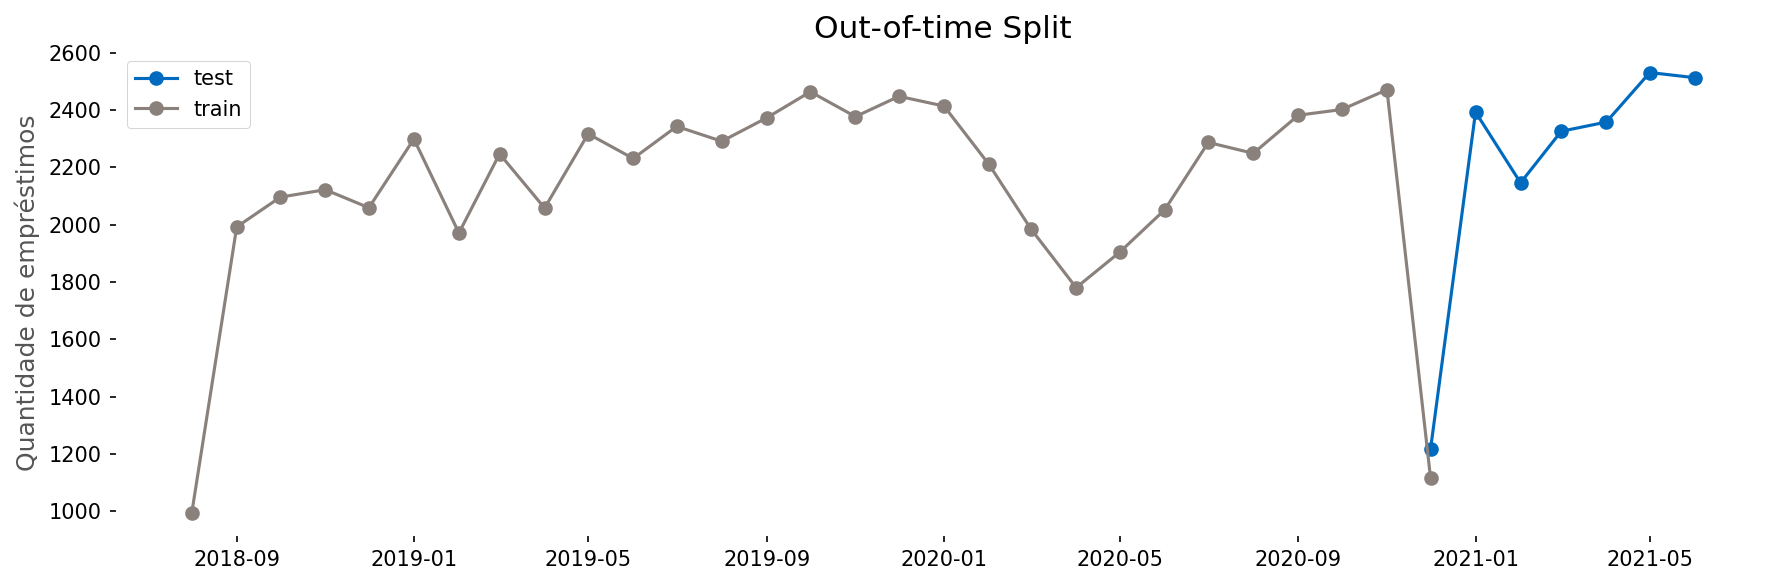

In [9]:
train_test = pd.concat([train, test])
train_test = (
    train_test
    .groupby(['SAFRA_REF', 'SET'])['INADIMPLENTE']
    .count()
    .reset_index()
)


fig, ax = plt.subplots(figsize=(12, 4))
plt.title('Out-of-time Split', fontsize=15)

for set_name, df_set in train_test.groupby('SET'):
    ax.plot(df_set['SAFRA_REF'], df_set['INADIMPLENTE'], marker='o', label=set_name)

ax.set_ylabel('Quantidade de empréstimos')
ax.legend()
plt.grid(False)
plt.tight_layout()
plt.show()


O gráfico mostra que o OOT-split é consistente e bem definido:
- O conjunto de teste representa um período futuro com volume semelhante ao do treino, preservando tendência e sazonalidade mensais. Isso evita data leakage e garante uma avaliação realista da capacidade de generalização temporal do modelo.
- Podemos observar variações relevantes no volume de empréstimos ao longo do tempo. Entre o final de 2019 e meados de 2020 há uma redução gradual nas emissões, possivelmente refletindo mudanças sazonais ou condições econômicas adversas. Um comportamento semelhante, porém mais acentuado, ocorre no final de 2020 e início de 2021, quando o volume cai de forma mais brusca antes de voltar a subir. Esses movimentos reforçam a importância do uso do Out-of-Time split, pois evidenciam variações temporais que o modelo precisa ser capaz de generalizar.

### **4. Análise univariada**

**Base de pagamentos**

In [10]:
train[['VALOR_A_PAGAR', 'TAXA', 'DIAS_ATRASO', 'INADIMPLENTE']].describe().T

,count,mean,std,min,25%,50%,75%,max
VALOR_A_PAGAR,60997.00,44142.02,44897.17,0.10,17963.96,33256.00,58091.97,4400000.00
TAXA,61931.00,6.79,1.78,4.99,5.99,5.99,6.99,11.99
DIAS_ATRASO,61931.00,-0.07,25.25,-2661.00,0.00,0.00,0.00,869.00
INADIMPLENTE,61931.00,0.07,0.26,0.00,0.00,0.00,0.00,1.00


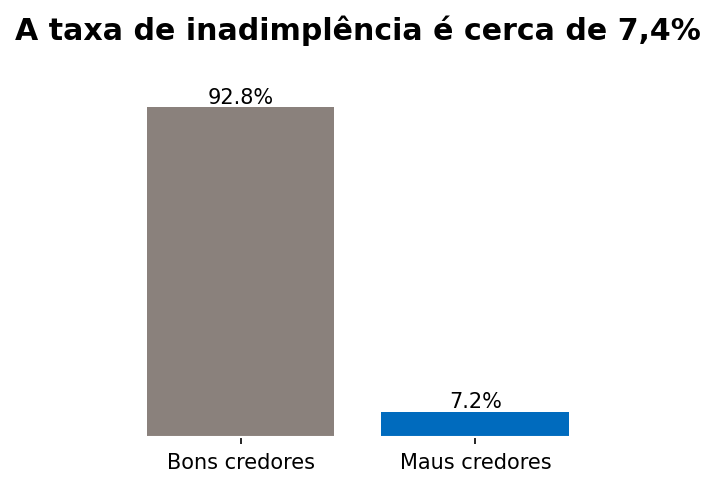

In [11]:
fig, ax = plt.subplots(figsize=(4, 3))

target_grouped = train.groupby(['INADIMPLENTE'])['INADIMPLENTE'].count().rename('count').reset_index().sort_values('count')

target_grouped['pct'] = target_grouped['count'] / target_grouped['count'].sum() * 100

bars = ax.bar(x=target_grouped['INADIMPLENTE'], height=target_grouped['pct'], color=instyle_palette)
for bar, pct in zip(bars, target_grouped['pct']):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{pct:.1f}%', ha='center', va='bottom')
ax.set_title('A taxa de inadimplência é cerca de 7,4%', pad=25, fontweight='bold')
ax.set_xticks(ticks=target_grouped['INADIMPLENTE'], labels=['Maus credores', 'Bons credores'])
ax.yaxis.set_visible(False)
ax.grid(False)

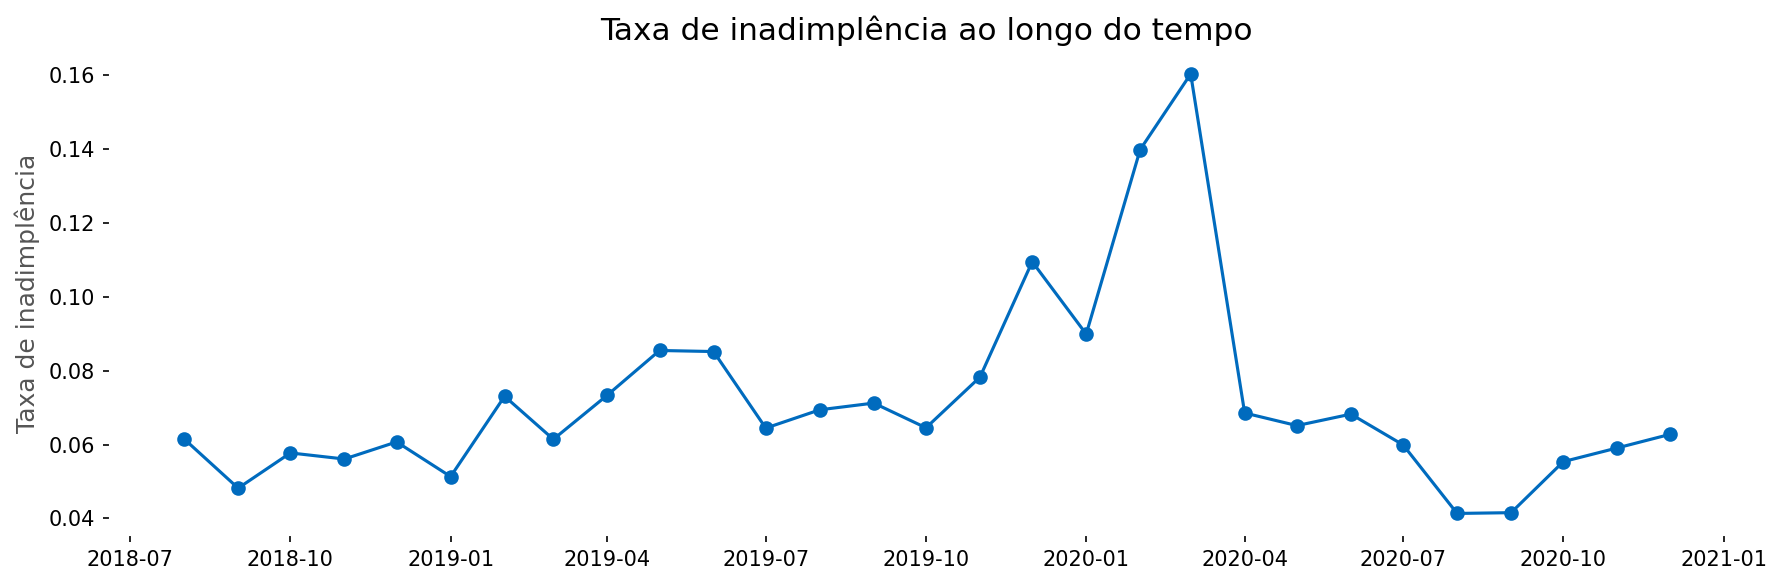

In [12]:
target_mean_train = (
    train
    .groupby('SAFRA_REF')['INADIMPLENTE']
    .mean()
    .reset_index(name='TARGET_MEAN')
)


fig, ax = plt.subplots(figsize=(12, 4))
plt.title('Taxa de inadimplência ao longo do tempo', fontsize=15)

ax.plot(
    target_mean_train['SAFRA_REF'],
    target_mean_train['TARGET_MEAN'],
    marker='o',
    label='TREINO'
)


ax.set_ylabel('Taxa de inadimplência')
plt.grid(False)
plt.tight_layout()
plt.show()

- Notamos um incremento nas taxas de inadimplência nos período do final de 2019 à Março de 2020.
- O pico de taxa de inadimplência ocorreu em Fevereiro de 2020, denotando quase que o dobro da média de taxa de inadimplência.

**4.1.2 Variáveis numéricas**

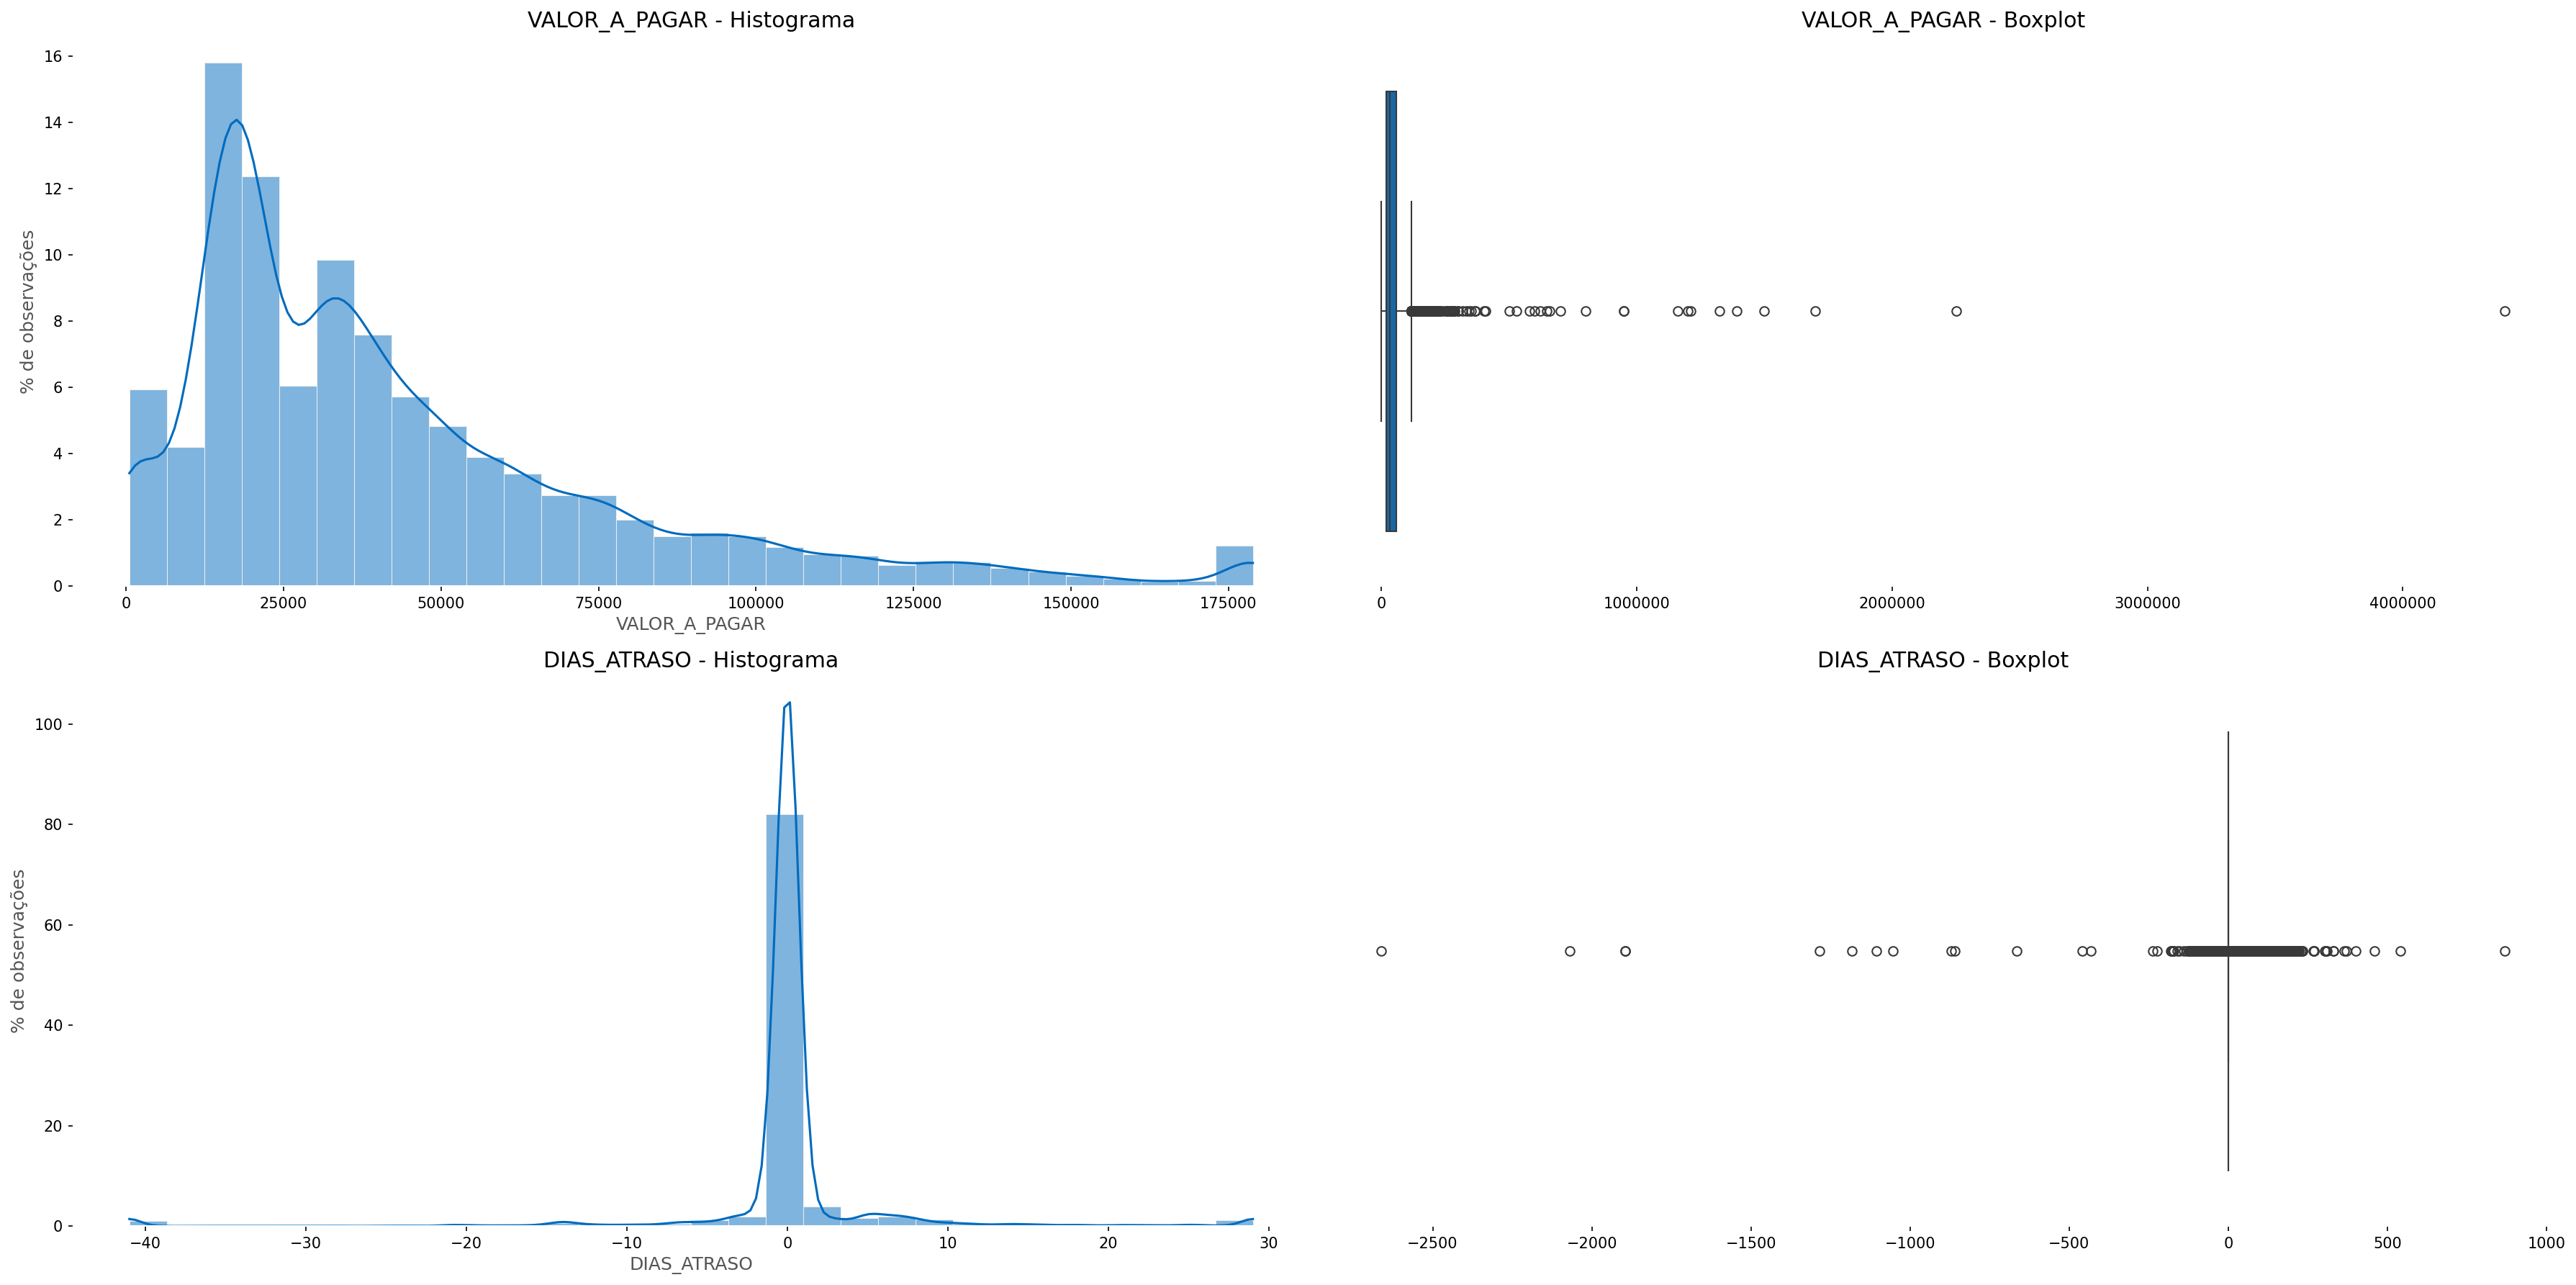

In [13]:
num_feats = ['VALOR_A_PAGAR', 'DIAS_ATRASO']

DataUtils.univariate_analysis_plots(train, num_feats, palette=instyle_palette, histplot=True, kde=True)

- Percebemos a presença de Outliers em todas as variáveis, entretanto, os valores a serem pagos se destacam nesse quesito. Apesar de existirem cobranças de mais de 4 milhões, cerca de 75% dos valores são até cerca de 58.000. Isso indica valores médios-altos, o que denota empresas ou contratos maiores. 
- Como já esperado, pagamentos adiantados e pontuais são a maioria, denotado pelo pico em torno de 0.


**Variáveis categóricas**

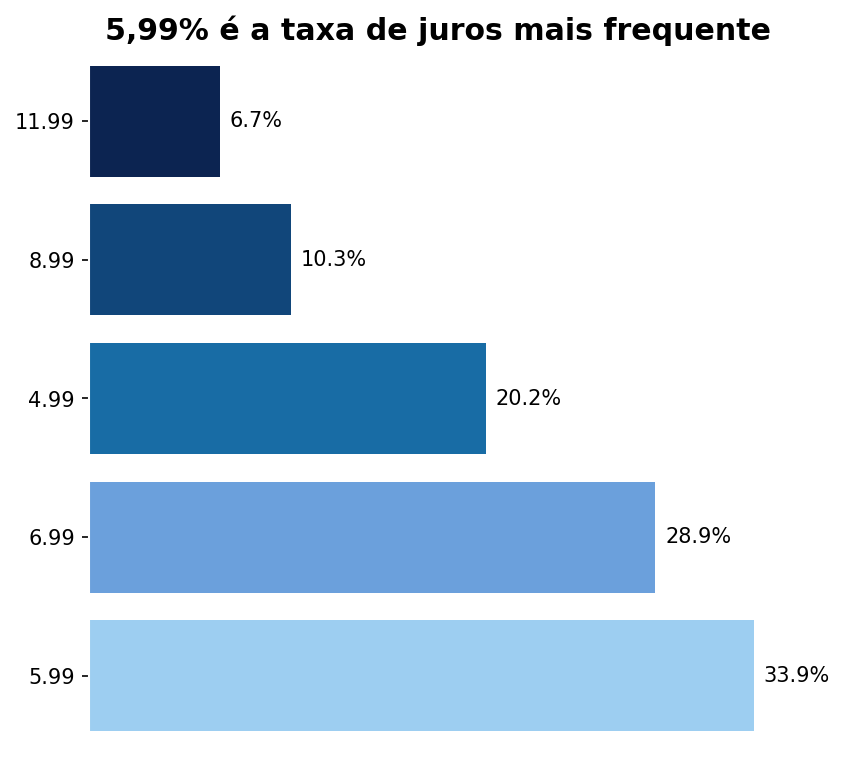

In [14]:
grouped = (
    train['TAXA']
    .value_counts(normalize=True)
    .mul(100)
    .reset_index()
)

grouped.columns = ['TAXA', 'proportion']

grouped = grouped.sort_values('proportion')


fig, ax = plt.subplots(figsize=(6, 6))

sns.barplot(
    data=grouped,
    x='proportion',
    y='TAXA',
    palette=progress_palette,
    order=grouped['TAXA'],
    ax=ax,
    orient='h'
)
ax.set_title('5,99% é a taxa de juros mais frequente', fontweight='bold')
ax.set_xlabel('')
ax.set_ylabel('')


for bar in ax.patches:
    width = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2

    ax.text(
        width + 0.5,
        y,
        f"{width:.1f}%",
        va="center",
        ha="left",
        fontsize=10
    )

ax.xaxis.set_visible(False)
ax.grid(False)
plt.show()


- Percebemos que a taxa de juros de 5,99% é a mais frequente no conjunto de treino. Ela representa aproxidamente 34% das taxas de transações de empréstimos. 
- Além disso, Quase 80% das taxas estão distríbuidas entre: 4,99%, 5,99%, 6,99%.

Como se comportam os outliers?

In [15]:
outliers = DataUtils.detect_outliers_iqr(train['VALOR_A_PAGAR'])

print(f'Total: {outliers.shape[0]}')
print(f'PCT: {(outliers.shape[0] / train.shape[0]) * 100:.2f}%')

outliers

Total: 3228
PCT: 5.21%


870      210851.55
869      153540.00
866      157490.35
853      127646.40
872      153309.86
873      207109.64
874      153309.86
890      137797.58
881      184451.40
880      137426.52
804      128419.79
803      180100.93
802      201482.40
950      159661.85
1610     176774.51
1601     158869.70
1703     154683.16
1699     118851.30
617      121251.95
616      129603.88
792      134589.40
787      134589.40
750      140332.95
1233     120191.35
1451     148380.05
1202     138209.72
1203     131927.45
1205     121329.00
1210     130662.00
1206     137401.50
1204     131927.45
1344     144326.40
1343     144835.04
1424     122047.87
1062     142857.18
1059     142857.18
1063     140606.99
1064     140606.99
1015     123006.04
365      132343.65
368      132343.65
328      129071.98
89       133221.74
436      145693.85
388      144024.73
394      151908.84
396      145687.75
190      144755.20
188      190201.60
605      147177.00
312      200834.48
315      196458.08
500      134

Vamos observar o comportamento dos clientes

In [16]:
outliers_idxs = outliers.index

outliers_df = train.loc[outliers_idxs]

outliers_df.head(15)

,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_PAGAMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA,DIAS_ATRASO,INADIMPLENTE,SET
870,5726178124659660800,2018-08-01,2018-08-22,2018-09-10,2018-09-10,210851.55,5.99,0,0,train
869,5726178124659660800,2018-08-01,2018-08-22,2018-09-10,2018-09-10,153540.00,5.99,0,0,train
866,5726178124659660800,2018-08-01,2018-08-20,2018-09-10,2018-09-10,157490.35,5.99,0,0,train
853,7816319470107777024,2018-08-01,2018-08-26,2018-09-13,2018-09-13,127646.40,4.99,0,0,train
872,5726178124659660800,2018-08-01,2018-08-26,2018-09-14,2018-09-14,153309.86,5.99,0,0,train
873,5726178124659660800,2018-08-01,2018-08-30,2018-09-17,2018-09-17,207109.64,5.99,0,0,train
874,5726178124659660800,2018-08-01,2018-08-31,2018-09-18,2018-09-19,153309.86,5.99,-1,0,train
890,8409181491723988992,2018-08-01,2018-08-20,2018-09-11,2018-09-11,137797.58,4.99,0,0,train
881,5611787644735474688,2018-08-01,2018-08-29,2018-09-14,2018-09-14,184451.40,8.99,0,0,train
880,5611787644735474688,2018-08-01,2018-08-20,2018-09-05,2018-09-05,137426.52,8.99,0,0,train


In [19]:
outliers_grouped = (
    outliers_df
    .groupby('ID_CLIENTE')
    .agg(
        mean_valor=('VALOR_A_PAGAR', 'mean'),
        n_trans=('VALOR_A_PAGAR', 'size')
    )
    .reset_index()
)

not_outlier = train.loc[~train.index.isin(outliers_df.index)]

not_out_matched = not_outlier.loc[
    not_outlier['ID_CLIENTE'].isin(outliers_df['ID_CLIENTE'].unique())
]

not_out_grouped = (
    not_out_matched
    .groupby('ID_CLIENTE')
    .agg(
        mean_valor=('VALOR_A_PAGAR', 'mean'),
        n_trans=('VALOR_A_PAGAR', 'size')
    )
    .reset_index()
)


print(f"Quantidade de clientes com OUTLIER: {outliers_grouped['ID_CLIENTE'].nunique()}\n")

print(f"Média de VALOR_A_PAGAR por cliente (OUTLIER): "
      f"{outliers_grouped['mean_valor'].mean():.2f}")
print(f"Média de transações por cliente (OUTLIER): "
      f"{outliers_grouped['n_trans'].mean():.2f}\n")

print(f"Média de VALOR_A_PAGAR por cliente (N/OUTLIER): "
      f"{not_out_grouped['mean_valor'].mean():.2f}")
print(f"Média de transações por cliente (N/OUTLIER): "
      f"{not_out_grouped['n_trans'].mean():.2f}")


Quantidade de clientes com OUTLIER: 233

Média de VALOR_A_PAGAR por cliente (OUTLIER): 176960.85
Média de transações por cliente (OUTLIER): 13.85

Média de VALOR_A_PAGAR por cliente (N/OUTLIER): 60091.63
Média de transações por cliente (N/OUTLIER): 85.06


A análise dos outliers mostrou que 233 clientes apresentam ao menos um mês classificado como extremo em RENDA_MES_ANTERIOR. Ao comparar o comportamento financeiro desses clientes, observamos que, nos meses considerados outliers, o valor médio das operações (VALOR_A_PAGAR) alcança aproximadamente R$ 176.960,85, enquanto a média de transações deste tipo é de apenas 13,85. 

Por outro lado, nos casos não-outliers desses mesmos clientes, o ticket médio cai para cerca de R$ 60.091,63, ao mesmo tempo em que o número médio de transações feitas aumenta substancialmente para 85,06. 

Essa relação inversa menos transações, porém de maior valor reforça que os outliers não representam distorções ou erros na base, mas sim períodos em que os clientes realizam operações esporádicas, porém de grande porte. Portanto, esses registros contêm informação relevante sobre o comportamento econômico dos clientes e devem ser mantidos no conjunto de treino para preservar o sinal financeiro capturado pelo modelo.

**Missings**

In [17]:
DataUtils.find_na_ocurrences_by_ids(train['ID_CLIENTE'], train, ['VALOR_A_PAGAR'])

,feature,mean_na_count,max_na_count,min_na_count,mean_na_pct,max_na_pct,min_na_pct
0,VALOR_A_PAGAR,0.82,16,0,0.01,0.50,0.00


Observamos que a média de ocorrências de valores nulos por cliente é baixíssima, cerca de 0,01%. Dessa forma, podemos imputar os valores históricos de cada cliente, utilizando ffill e bfill.

In [ ]:
train['VALOR_A_PAGAR'] = (
        train
        .groupby('ID_CLIENTE')['VALOR_A_PAGAR']
        .ffill()

    )

train['VALOR_A_PAGAR'] = train['VALOR_A_PAGAR'].fillna(train['VALOR_A_PAGAR'].median() )


**Base cadastral**

Esta base só possui variáveis categóricas, dessa forma, torna-se desnecessário a análise de variáveis numéricas.

In [19]:
base_cadastral = DataUtils.read_data(file='base_cadastral.xlsx', file_type='xlsx', processed=True)

..\data\processed\base_cadastral.xlsx


In [20]:
base_cadastral.head()

,ID_CLIENTE,DATA_CADASTRO,DDD,FLAG_PF,SEGMENTO_INDUSTRIAL,DOMINIO_EMAIL,PORTE,CEP_2_DIG
0,1661240395903230976,2013-08-22,99,0,Serviços,YAHOO,PEQUENO,65.00
1,8274986328479596544,2017-01-25,31,0,Comércio,YAHOO,MEDIO,77.00
2,345447888460137920,2000-08-15,75,0,Serviços,HOTMAIL,PEQUENO,48.00
3,1003144834589372032,2017-08-06,49,0,Serviços,OUTLOOK,PEQUENO,89.00
4,324916756972236032,2011-02-14,88,0,Serviços,GMAIL,GRANDE,62.00


O primeiro passo, é garantir que vejamos apenas os registros que estão presentes no conjunto de treinamento. Desa forma, vamos filtrar os registros pelos ids presentes neste conjunto.

In [21]:
ids_train = train['ID_CLIENTE'].unique()

train_bc = base_cadastral[base_cadastral['ID_CLIENTE'].isin(ids_train)]

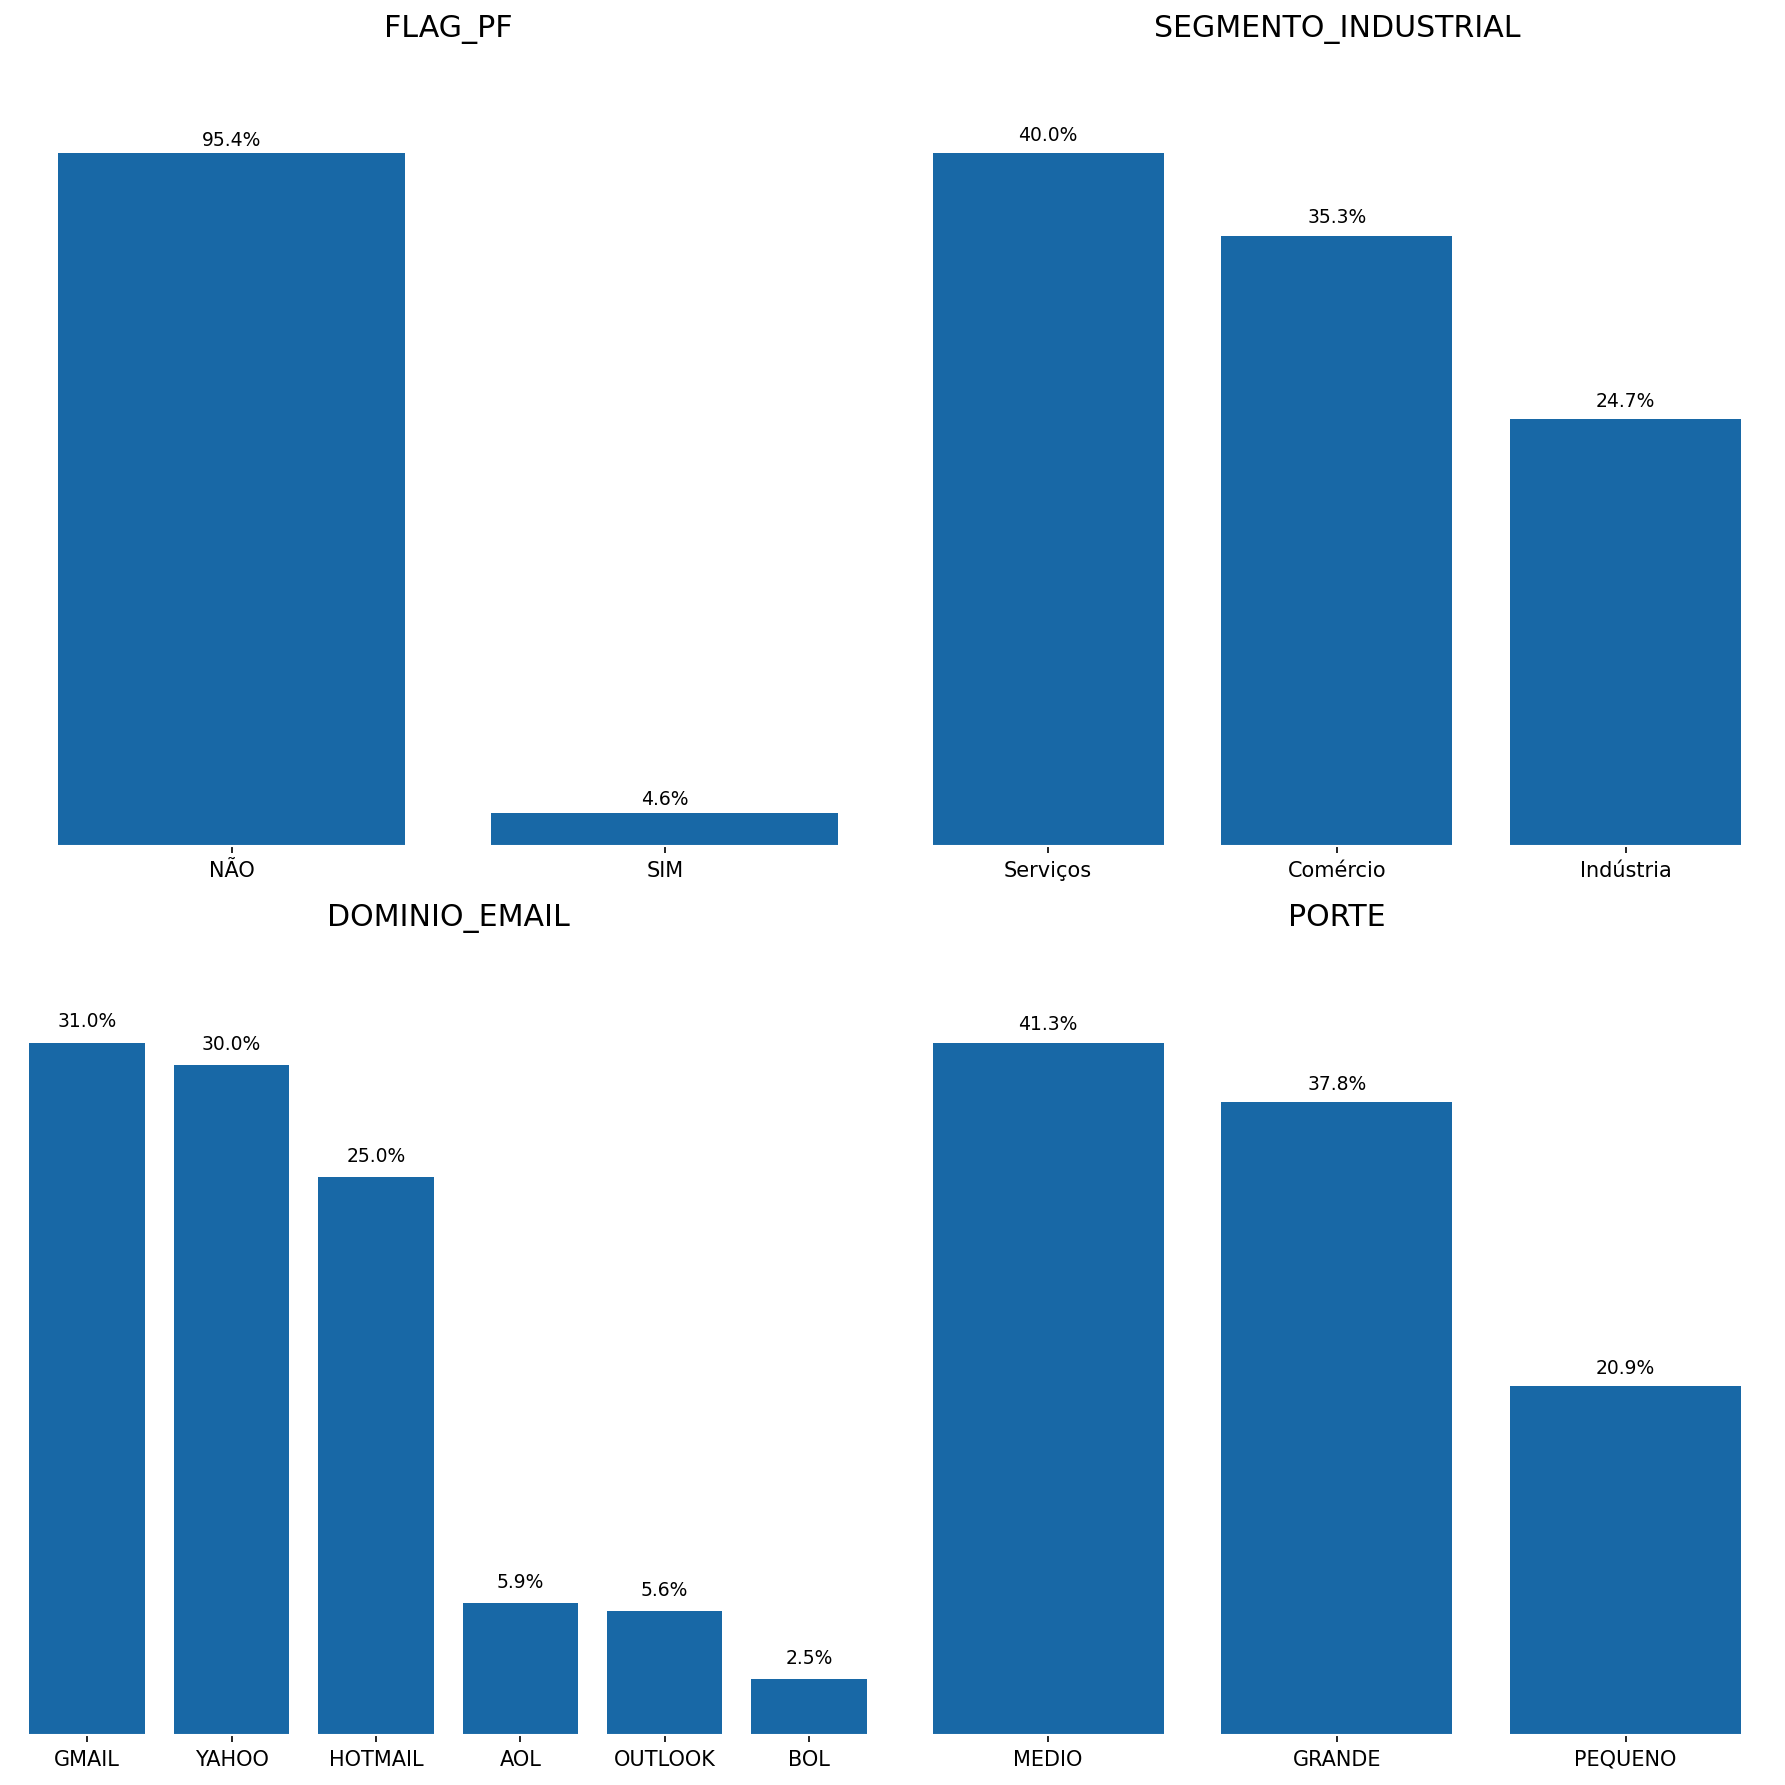

In [22]:
cat_feats = ['FLAG_PF', 'SEGMENTO_INDUSTRIAL', 'DOMINIO_EMAIL', 'PORTE']

n = len(cat_feats)
n_cols = 2
n_rows = (n + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 6 * n_rows))
axes = axes.flatten()

train_bc_copy = train_bc.copy()
train_bc_copy['FLAG_PF'] = train_bc_copy['FLAG_PF'].map(lambda x: 'SIM' if x == 1 else 'NÃO')

for ax, col in zip(axes, cat_feats):
    grouped = (
        train_bc_copy[col]
        .value_counts(normalize=True)
        .mul(100)
        .reset_index()
    )
    grouped.columns = [col, 'pct']
    grouped = grouped.sort_values('pct', ascending=False)

    sns.barplot(data=grouped, x=col, y='pct', ax=ax)
    ax.set_title(col)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_yticks([])

    for p in ax.patches:
        height = p.get_height()
        ax.text(
            p.get_x() + p.get_width() / 2,
            height + 0.5,
            f'{height:.1f}%',
            ha='center',
            va='bottom',
            fontsize=9
        )

    ax.set_ylim(0, grouped['pct'].max() * 1.15)
    ax.grid(False)

for j in range(len(cat_feats), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


- Percebemos a presença massiva de clientes que não são pessoa física (empresas), cerca de pouco mais de 95%.
- O segmento industrial que mais está presente no conjunto de dados é o de Serviços, representando 40% dos clientes.
- Domínios de e-mail como: GMAIL, YAHOO e HOTMAIL são os mais presentes no conjunto de dados, somados representam 86% de todos os registros.
- Cerca de 79% dos clientes estão classificados com seu porte em médio e grande. Isso reforça a presença de contratos de médio-alto valor, o qual vimos durante a análise da base de pagamentos.

**DDD e CEP**

In [ ]:
mask_valid = train_bc_copy['DDD'] != 'INVÁLIDO'

train_bc_copy['REGIAO_DDD'] = np.where(
    mask_valid,
    train_bc_copy['DDD'].str[0],
    np.nan
)

train_bc_copy['REGIAO_DDD'].head(10)

0    9
1    3
2    7
3    4
4    8
5    1
6    6
7    2
8    1
9    4
Name: REGIAO_DDD, dtype: object

In [ ]:


cep_str = (
    train_bc_copy['CEP_2_DIG']
    .astype('Int64')
    .astype(str)
    .where(train_bc_copy['CEP_2_DIG'].notna(), other=np.nan)  # volta NaN onde era NaN
)

mask_valid = cep_str.notna()


train_bc_copy['REGIAO_CEP'] = np.where(
    mask_valid,
    cep_str.str[0],
    np.nan
)


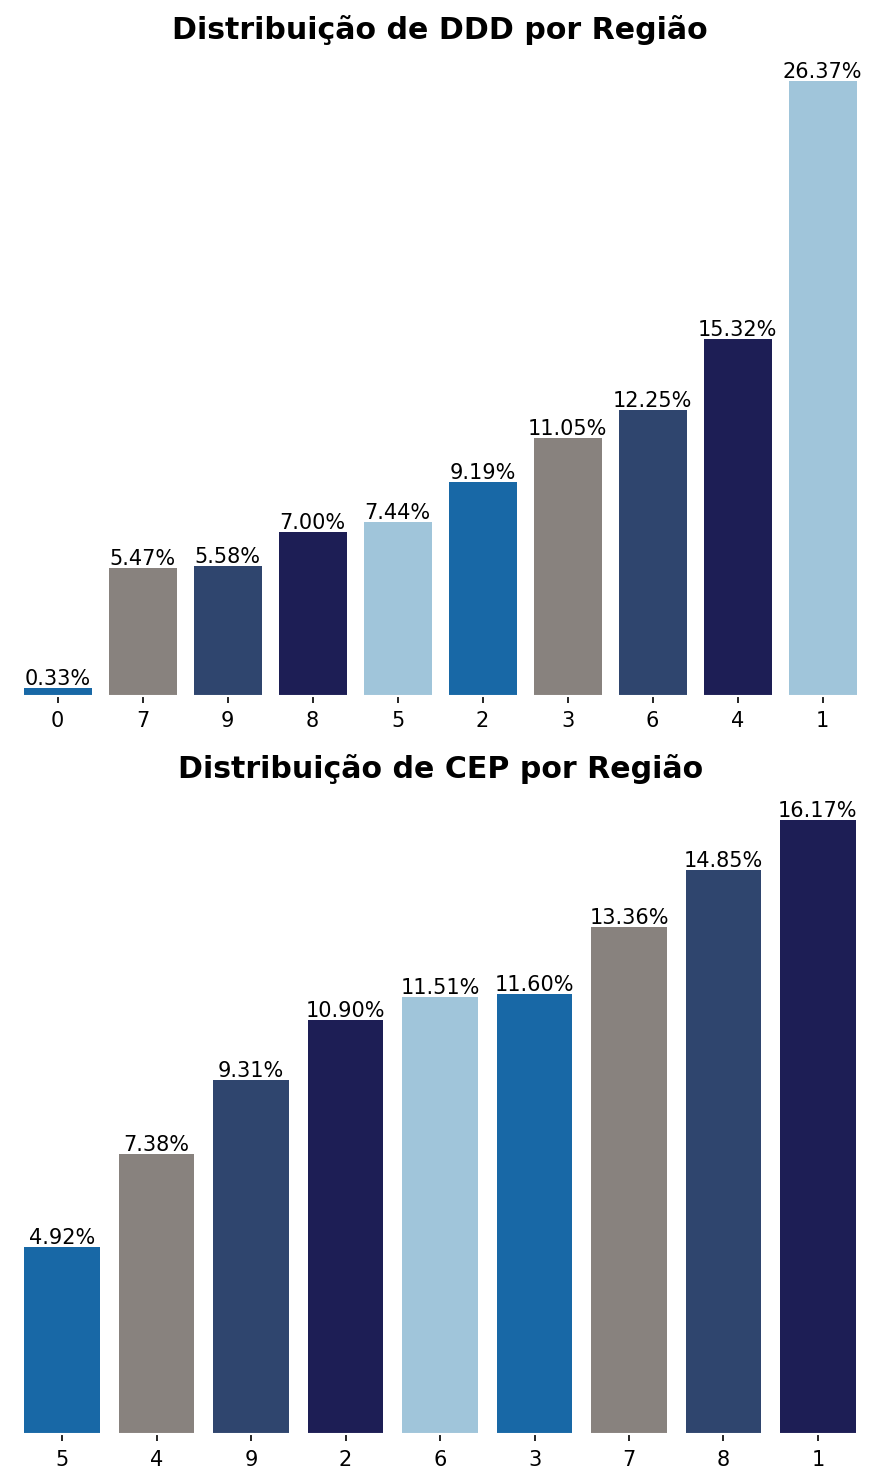

In [ ]:
grouped_bc_ddd = (
    train_bc_copy['REGIAO_DDD']
    .value_counts(normalize=True)
    .mul(100)
    .reset_index()
    .sort_values('proportion')
)

grouped_bc_cep = (
    train_bc_copy['REGIAO_CEP']
    .value_counts(normalize=True)
    .mul(100)
    .reset_index()
    .sort_values('proportion')
)

fig, axes = plt.subplots(2, 1, figsize=(6, 10))
axes = axes.flatten()

sns.barplot(
    data=grouped_bc_ddd,
    x='REGIAO_DDD',
    y='proportion',
    palette=instyle_palette,
    ax=axes[0]
)
axes[0].set_title('Distribuição de DDD por Região', fontweight='bold')
axes[0].set_xlabel('')
axes[0].set_ylabel('')
axes[0].yaxis.set_visible(False)
axes[0].grid(False)

for bar in axes[0].patches:
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    axes[0].text(
        x=x,
        y=y,
        s=f'{y:.2f}%',
        color='black',
        va='bottom', ha='center'
    )

# CEP
sns.barplot(
    data=grouped_bc_cep,
    x='REGIAO_CEP',
    y='proportion',
    palette=instyle_palette,
    ax=axes[1]
)
axes[1].set_title('Distribuição de CEP por Região', fontweight='bold')
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].yaxis.set_visible(False)
axes[1].grid(False)

for bar in axes[1].patches:
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    axes[1].text(
        x=x,
        y=y,
        s=f'{y:.2f}%',
        color='black',
        va='bottom', ha='center'
    )

plt.tight_layout()
plt.show()


- Percebemos que a região 1 (São Paulo) por DDD é mais presente no conjunto de treinamento
- Confirmando a afirmação anterior, percebemos que a região 1 (CEPs de São Paulo) são as mais presentes em registros.

**Base info**

Esta base só possui variáveis numéricas, portanto, torna-se desnecessária a análise de variáveis categóricas.

In [26]:
base_info = DataUtils.read_data(file='base_info.xlsx', file_type='xlsx', processed=True)

base_info.head()

..\data\processed\base_info.xlsx


,ID_CLIENTE,SAFRA_REF,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS
0,1661240395903230976,2018-09-01,16913.00,NaN
1,8274986328479596544,2018-09-01,106430.00,141.00
2,345447888460137920,2018-09-01,707439.00,99.00
3,1003144834589372032,2018-09-01,239659.00,96.00
4,324916756972236032,2018-09-01,203123.00,103.00


Assim como na 'base_cadastral', é essencial garantir que todos os registros correspondam com os ids presentes no conjunto de treinamento de pagamentos, dessa forma, vamos novamente filtrar e garantir que essa correspondência ocorra.

In [27]:
train_bi = base_info[base_info['ID_CLIENTE'].isin(ids_train)]

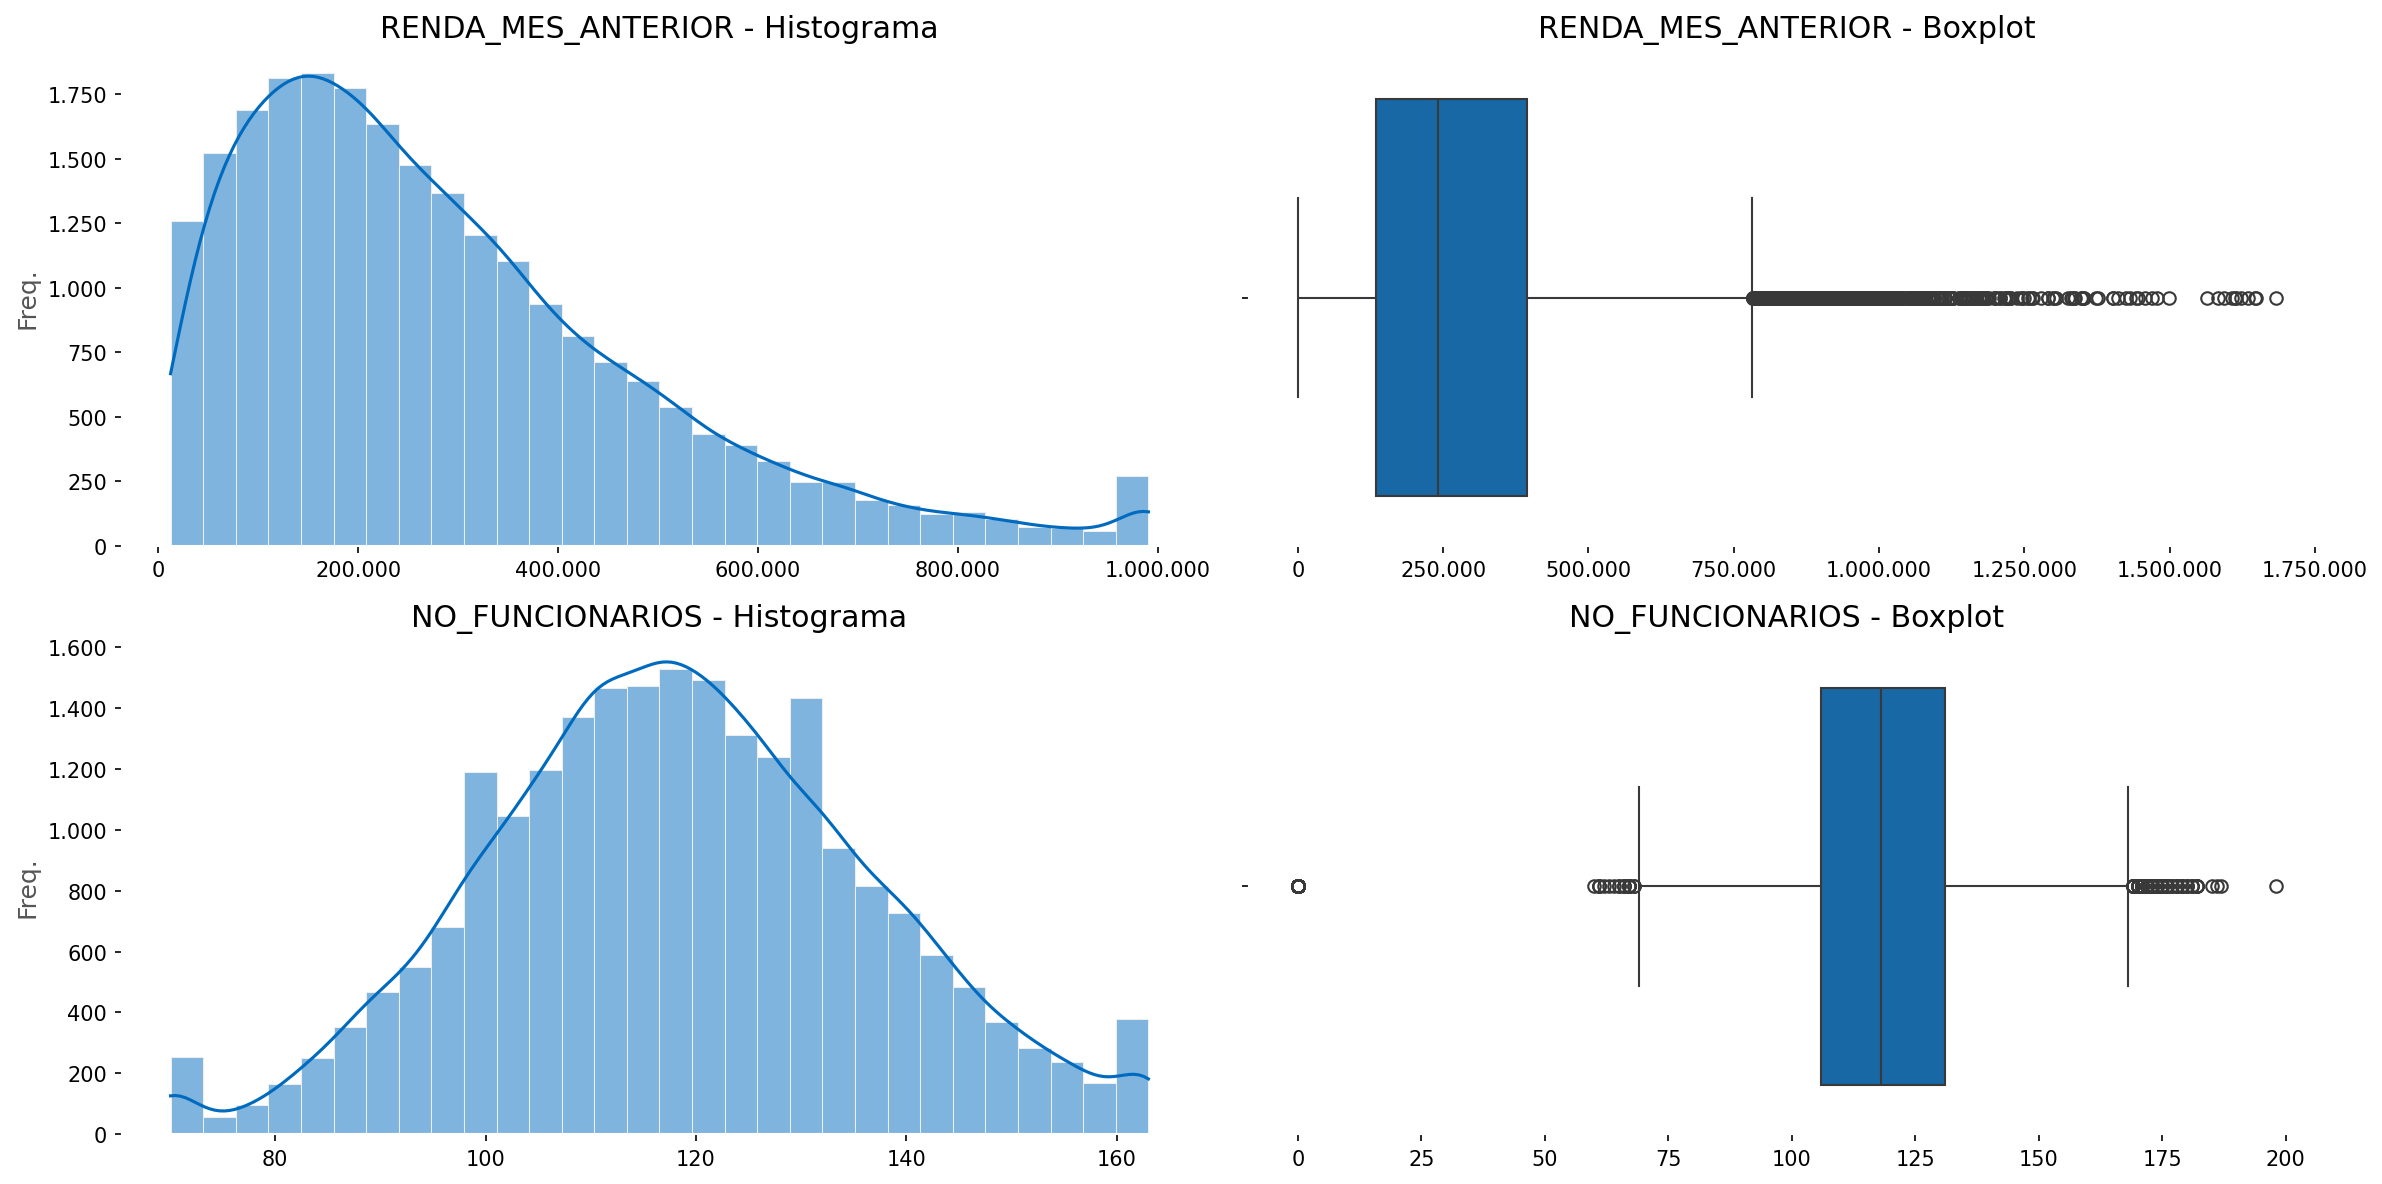

In [28]:
num_feats = ['RENDA_MES_ANTERIOR', 'NO_FUNCIONARIOS']
from matplotlib.ticker import FuncFormatter, PercentFormatter

fig, axes = plt.subplots(2, 2, figsize=(16, 8))

for row, col in enumerate(num_feats):
    s = train_bi[col].dropna()
    lo = s.quantile(0.01)
    hi = s.quantile(0.99)
    s_clip = s.clip(lo, hi)

    ax_hist = axes[row, 0]
    sns.histplot(x=s_clip, kde=True, bins=30, ax=ax_hist, palette=instyle_palette)
    ax_hist.set_title(f"{col} - Histograma")
    ax_hist.set_xlabel('')
    ax_hist.set_ylabel('Freq.')
    ax_hist.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f"{x:,.0f}".replace(",", ".")))
    ax_hist.grid(False)
    ax_hist.xaxis.set_major_formatter(FuncFormatter(lambda x, p: f"{x:,.0f}".replace(",", ".")))

    ax_box = axes[row, 1]
    sns.boxplot(x=s, ax=ax_box, palette=instyle_palette, orient="h")
    ax_box.set_title(f"{col} - Boxplot")
    ax_box.set_xlabel('')
    ax_box.set_ylabel('')
    ax_box.grid(False)
    ax_box.xaxis.set_major_formatter(FuncFormatter(lambda x, p: f"{x:,.0f}".replace(",", ".")))

plt.tight_layout()
plt.show()

- Percebemos a distorção na cauda a direita da variável de RENDA_MES_ANTERIOR. Isso denota a presença de Outliers, que podem chegar a 1.750.000. Entretanto, sua média fica por volta de 250.000,00.
- Notamos que grande parte dos clientes possuem ao menos mais de 50 funcionários. Mais uma vez reforçando o porte e tamanho dos contratos já discutidos.

Analisaremos agora a presença dos outliers

In [29]:
outliers = DataUtils.detect_outliers_iqr(train_bi['RENDA_MES_ANTERIOR'])

print(f'Quantidade de outliers: {outliers.count()}')
outliers.head(15)

Quantidade de outliers: 741


123   1032413.00
218   1373712.00
270    831001.00
296    921781.00
297    939315.00
325    852656.00
327    944288.00
408    999601.00
463    829531.00
510    801078.00
525    798645.00
532   1215737.00
604   1007924.00
612    883110.00
654    851763.00
Name: RENDA_MES_ANTERIOR, dtype: float64

Quantos clientes diferentes estão classificados como outliers?

In [30]:
outliers_df = train_bi.loc[outliers.index]

print(f'Clientes únicos classificados como outliers: {outliers_df['ID_CLIENTE'].nunique()}')
print(f'Total: {outliers_df.shape[0]}')

outliers_df.head(15)

Clientes únicos classificados como outliers: 495
Total: 741


,ID_CLIENTE,SAFRA_REF,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS
123,851897122328714368,2018-09-01,1032413.00,93.00
218,1616952665234408960,2018-09-01,1373712.00,99.00
270,5048392903148444672,2018-09-01,831001.00,96.00
296,2761181567313019904,2018-09-01,921781.00,73.00
297,3698481516392183808,2018-09-01,939315.00,126.00
325,4850722092974676992,2018-09-01,852656.00,119.00
327,66220087398241664,2018-09-01,944288.00,89.00
408,5577659616907513856,2018-09-01,999601.00,116.00
463,9098842671739011072,2018-09-01,829531.00,111.00
510,8083157716178259968,2018-09-01,801078.00,121.00


In [31]:
train_bi['is_outlier'] = train_bi.index.isin(outliers_df.index)


train_bi.groupby('is_outlier')[['RENDA_MES_ANTERIOR', 'NO_FUNCIONARIOS']].describe().T

is_outlier                   False      True 
RENDA_MES_ANTERIOR count  22377.00     741.00
                   mean  267268.95  954460.78
                   std   174008.38  165345.95
                   min      105.00  782431.00
                   25%   131189.00  832779.00
                   50%   233175.00  904858.00
                   75%   374125.00 1025952.00
                   max   781646.00 1682759.00
NO_FUNCIONARIOS    count  21896.00     710.00
                   mean     117.69     119.25
                   std       21.32      17.38
                   min        0.00      73.00
                   25%      106.00     107.00
                   50%      118.00     119.00
                   75%      131.00     131.00
                   max      198.00     169.00

Por hora, manteremos os Outliers que, de certa forma, em casos de modelagem como este, são comuns de serem visto. Ao realizar a análise multivariada, observaremos melhor, como se comportam estes outliers com as demais variáveis.

Vamos verificar, agora o comportamento das colunas que apresentam missings.

In [32]:
df_train_bi_na = train_bi.loc[train_bi['RENDA_MES_ANTERIOR'].isna()]


df_train_bi_na.head(20)

,ID_CLIENTE,SAFRA_REF,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS,is_outlier
53,382095722273502016,2018-09-01,NaN,79.00,False
61,4061297388883390976,2018-09-01,NaN,104.00,False
62,8961924617442201600,2018-09-01,NaN,100.00,False
70,3218792504195936256,2018-09-01,NaN,102.00,False
115,5897410907783139328,2018-09-01,NaN,NaN,False
156,1210783884008132096,2018-09-01,NaN,87.00,False
225,6337915293429442560,2018-09-01,NaN,111.00,False
305,3156852928909454848,2018-09-01,NaN,111.00,False
339,7451017400765373440,2018-09-01,NaN,92.00,False
342,4102750661040920064,2018-09-01,NaN,81.00,False


In [33]:
df_train_bi_na['ID_CLIENTE'].nunique()

462

In [34]:
print(train_bi['ID_CLIENTE'].value_counts().mean())
print(train_bi['ID_CLIENTE'].value_counts().max())
print(train_bi['ID_CLIENTE'].value_counts().min())

20.914837576821775
40
1


Vamos ver algumas métricas, como:
- Média, Máximo e Mínimo da quantidade de valores NA na coluna RENDA_MES_ANTERIOR e NO_FUNCIONARIOS por ID_CLIENTE
- Média, Máximo e Mínimo da porcentagem em relação ao total de valores NA na coluna RENDA_MES_ANTERIOR e NO_FUNCIONARIOS por ID_CLIENTE

In [35]:
metrics_renda = DataUtils.find_na_ocurrences_by_ids(
    id_cols=['ID_CLIENTE'],
    data=df_train_bi_na,
    features=['RENDA_MES_ANTERIOR', 'NO_FUNCIONARIOS']
)

metrics_renda

,feature,mean_na_count,max_na_count,min_na_count,mean_na_pct,max_na_pct,min_na_pct
0,RENDA_MES_ANTERIOR,1.52,5,1,1.00,1.00,1.00
1,NO_FUNCIONARIOS,0.07,1,0,0.04,1.00,0.00


Observamos que nenhum cliente apresenta uma proporção elevada de valores faltantes na variável RENDA_MES_ANTERIOR. Como a maior parte das informações está presente e distribuída ao longo do tempo, é possível preencher os valores ausentes utilizando o próprio histórico do cliente. Para isso, adotamos o método ffill (forward fill), que substitui cada valor faltante pelo último valor conhecido no tempo, garantindo consistência temporal.

In [ ]:
train_bi = train_bi.sort_values(['ID_CLIENTE', 'SAFRA_REF'])

cols_to_impute = ['NO_FUNCIONARIOS', 'RENDA_MES_ANTERIOR']

for col in cols_to_impute:
    train_bi[col] = (
        train_bi
        .groupby('ID_CLIENTE')[col]
        .ffill()
    )

    for col in cols_to_impute:
        median = train_bi[col].median()
        train_bi[col] = train_bi[col].fillna(median)

train_bi.isna().sum()

ID_CLIENTE            0
SAFRA_REF             0
RENDA_MES_ANTERIOR    0
NO_FUNCIONARIOS       0
is_outlier            0
dtype: int64

### 5. Análise Multivariada

Após a análise individual das variáveis, o próximo passo é avaliar como cada uma delas se relaciona com a variável alvo. Para isso, precisamos consolidar em um único dataset todas as informações disponíveis sobre os clientes. Assim, integraremos as bases cadastral e informacional à base de pagamentos, permitindo analisar o comportamento de inadimplência de forma completa e consistente.

In [37]:
final_train = pd.merge(
    left=train.sort_values('SAFRA_REF'),
    right=train_bc_copy,
    how='left',
    on='ID_CLIENTE'
).merge(
    on=['ID_CLIENTE', 'SAFRA_REF'],
    how='left',
    right=train_bi
)

final_train.head()

,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_PAGAMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA,DIAS_ATRASO,INADIMPLENTE,SET,DATA_CADASTRO,DDD,FLAG_PF,SEGMENTO_INDUSTRIAL,DOMINIO_EMAIL,PORTE,CEP_2_DIG,REGIAO_DDD,REGIAO_CEP,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS,is_outlier
0,1661240395903230976,2018-08-01,2018-08-17,2018-09-06,2018-09-06,35516.41,6.99,0,0,train,2013-08-22,99,NÃO,Serviços,YAHOO,PEQUENO,65.00,9,6,NaN,NaN,NaN
1,2025898153078563072,2018-08-01,2018-08-18,2018-09-18,2018-09-18,88567.80,6.99,0,0,train,2007-06-17,INVÁLIDO,NÃO,Serviços,GMAIL,PEQUENO,36.00,NaN,3,NaN,NaN,NaN
2,2451708306555441152,2018-08-01,2018-08-18,2018-09-04,2018-09-04,57024.80,6.99,0,0,train,2000-08-15,41,NÃO,Comércio,YAHOO,MEDIO,83.00,4,8,NaN,NaN,NaN
3,5301988619224057856,2018-08-01,2018-08-26,2018-09-11,2018-09-11,39089.52,6.99,0,0,train,2016-02-24,67,NÃO,Indústria,GMAIL,NaN,79.00,6,7,NaN,NaN,NaN
4,382095722273502016,2018-08-01,2018-08-27,2018-09-26,2018-09-26,32494.20,5.99,0,0,train,2011-02-14,11,NÃO,Indústria,YAHOO,PEQUENO,51.00,1,5,NaN,NaN,NaN


In [38]:
final_train.drop('is_outlier', inplace=True, axis=1)

**Existem features que estão correlacionadas umas com as outras?**

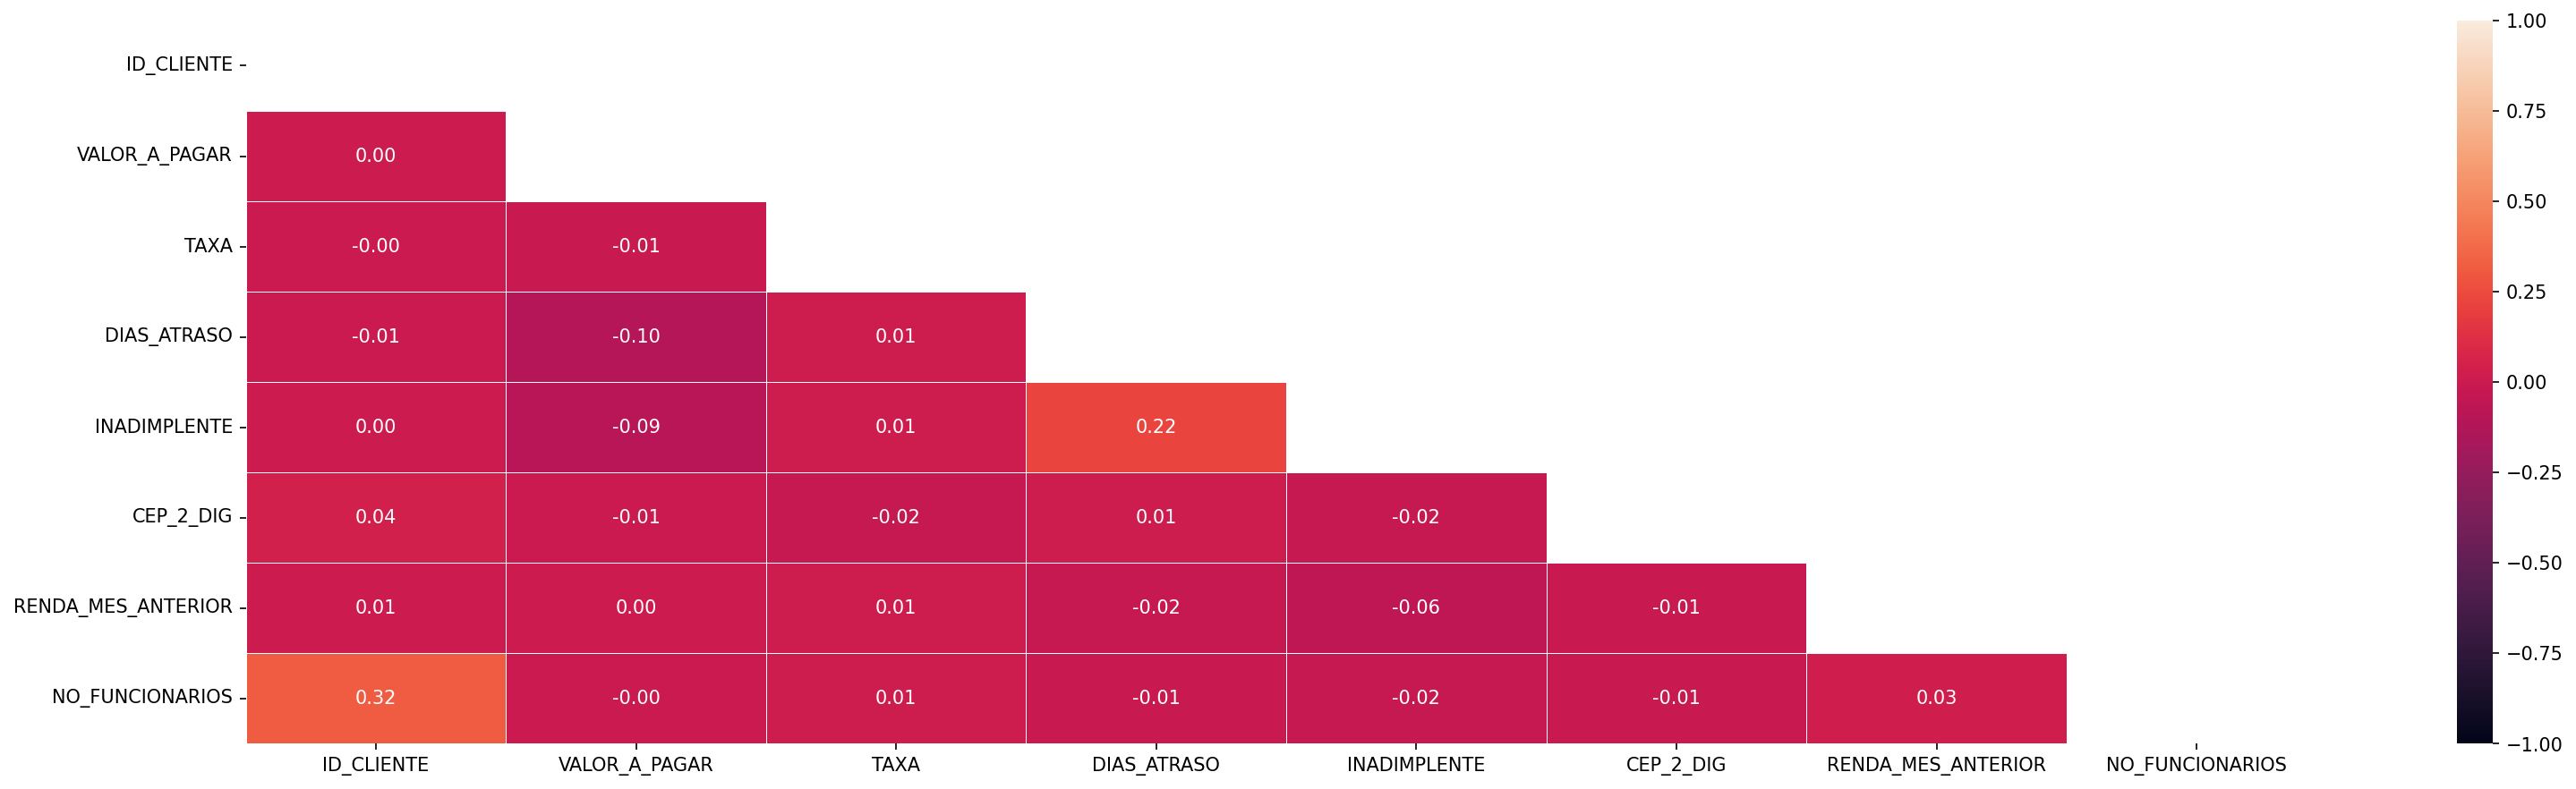

In [39]:
mask = np.zeros_like(final_train.corr(method='pearson', numeric_only=True), dtype=bool)
mask[np.triu_indices_from(mask)] = True

corr_matrix = final_train.corr(method='pearson', numeric_only=True)

plt.figure(figsize=(25, 7))
sns.heatmap(corr_matrix,linewidths=0.25, fmt=".2f", annot=True, vmin=-1, vmax=1, mask=mask)
plt.grid(False)
plt.show()

O heatmap Pearson mostra baixas correlações lineares entre as variáveis utilizadas e o target, o que é esperado em problemas de risco, onde os efeitos são não lineares e mais bem capturados por binning ou modelos de árvore.

A única correlação elevada é entre INADIMPLENTE e DIAS_ATRASO, reflexo direto da própria forma de construção do target. As demais correlações são baixas, indicando ausência de colinearidade linear relevante entre as variáveis.

**Variáveis categóricas**

**TAXA**

In [430]:
tax_df = DataUtils.woe_iv_table(
    data=final_train,
    feature='TAXA',
    target='INADIMPLENTE',
    bad_value=1,
    bins=None
)

tax_df

,n_obs,obs_proportion (%),good_row (%),bad_row (%),n_good,n_bad,good_col (%),bad_col (%),g/b,woe,iv
4.99,14676.00,20.28,92.86,7.14,13628.00,1048.00,20.26,20.55,0.99,-0.01,0.00
5.99,24689.00,34.11,93.58,6.42,23105.00,1584.00,34.35,31.06,1.11,0.10,0.00
6.99,20638.00,28.52,92.55,7.45,19100.00,1538.00,28.39,30.16,0.94,-0.06,0.00
8.99,7423.00,10.26,92.24,7.76,6847.00,576.00,10.18,11.29,0.90,-0.10,0.00
11.99,4944.00,6.83,92.84,7.16,4590.00,354.00,6.82,6.94,0.98,-0.02,0.00
total,72370.00,100.00,92.95,7.05,67270.00,5100.00,100.00,100.00,NaN,NaN,0.01


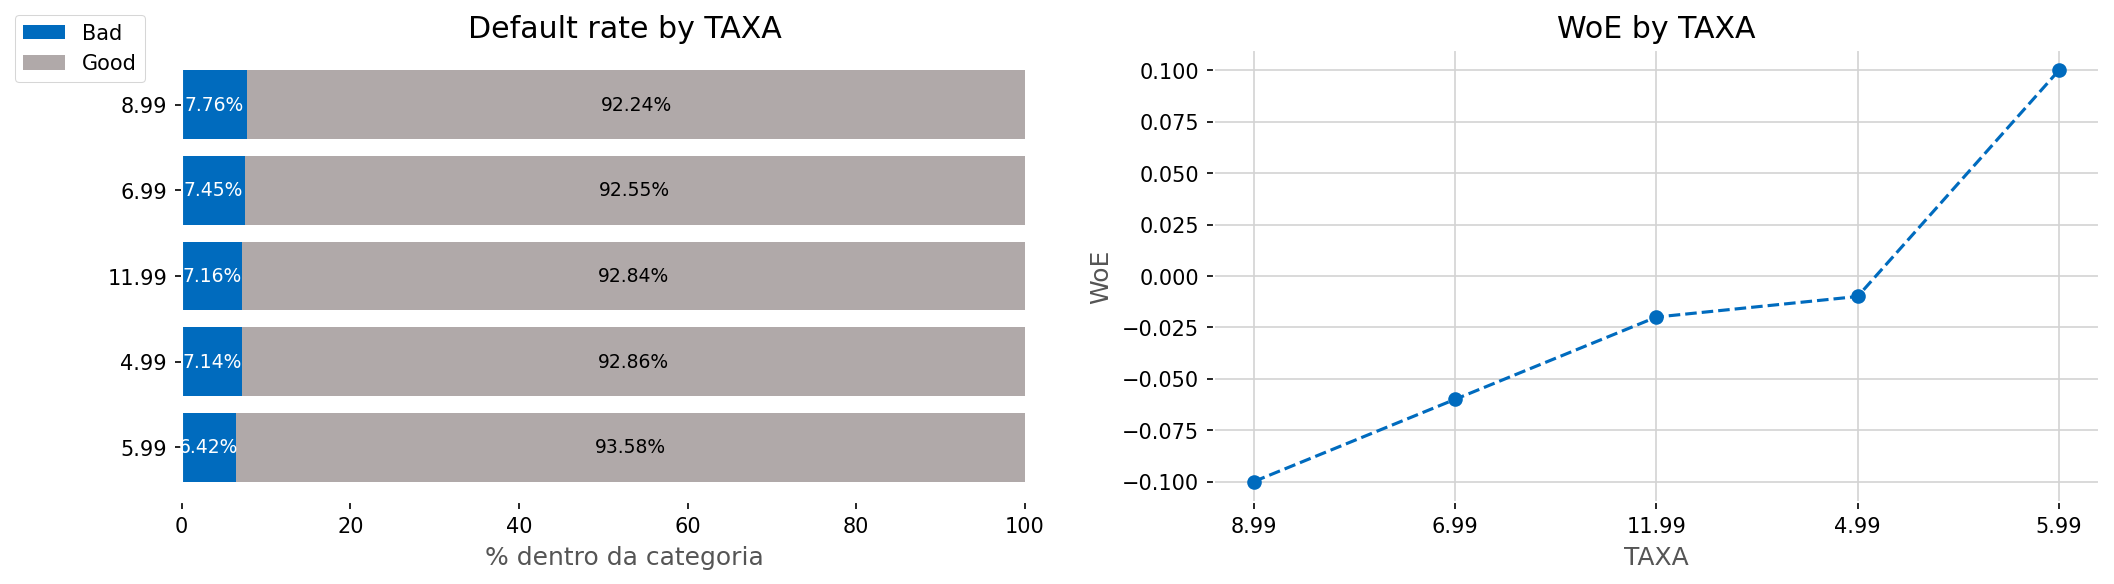

In [431]:
DataUtils.plot_default_woe(
    data=final_train,
    feature='TAXA',
    target='INADIMPLENTE',
    palette=instyle_palette
)

A variável TAXA apresenta baixa capacidade de separação de risco.
As diferentes faixas de taxa mostram taxas de inadimplência muito próximas entre si, variando de apenas 6.95% a 8.68%.

O gráfico de WoE reforça essa conclusão: os valores variam entre –0.17 e +0.07, indicando separação fraca e ausência de monotonicidade.

Portanto, TAXA provavelmente terá IV baixo (<0.02) e deve ser considerada variável fraca ou até removida da modelagem, dependendo da estratégia.

**SEGMENTO INDUSTRIAL**

In [432]:
si_df = DataUtils.woe_iv_table(
    data=final_train,
    feature='SEGMENTO_INDUSTRIAL',
    target='INADIMPLENTE',
    bad_value=1,
    bins=None
)

si_df

,n_obs,obs_proportion (%),good_row (%),bad_row (%),n_good,n_bad,good_col (%),bad_col (%),g/b,woe,iv
Comércio,25155.00,35.41,95.46,4.54,24014.00,1141.00,36.37,22.77,1.60,0.47,0.06
Indústria,16192.00,22.79,92.38,7.62,14958.00,1234.00,22.66,24.63,0.92,-0.08,0.00
Serviços,29687.00,41.79,91.12,8.88,27051.00,2636.00,40.97,52.60,0.78,-0.25,0.03
total,71034.00,100.00,92.95,7.05,66023.00,5011.00,100.00,100.00,NaN,NaN,0.09


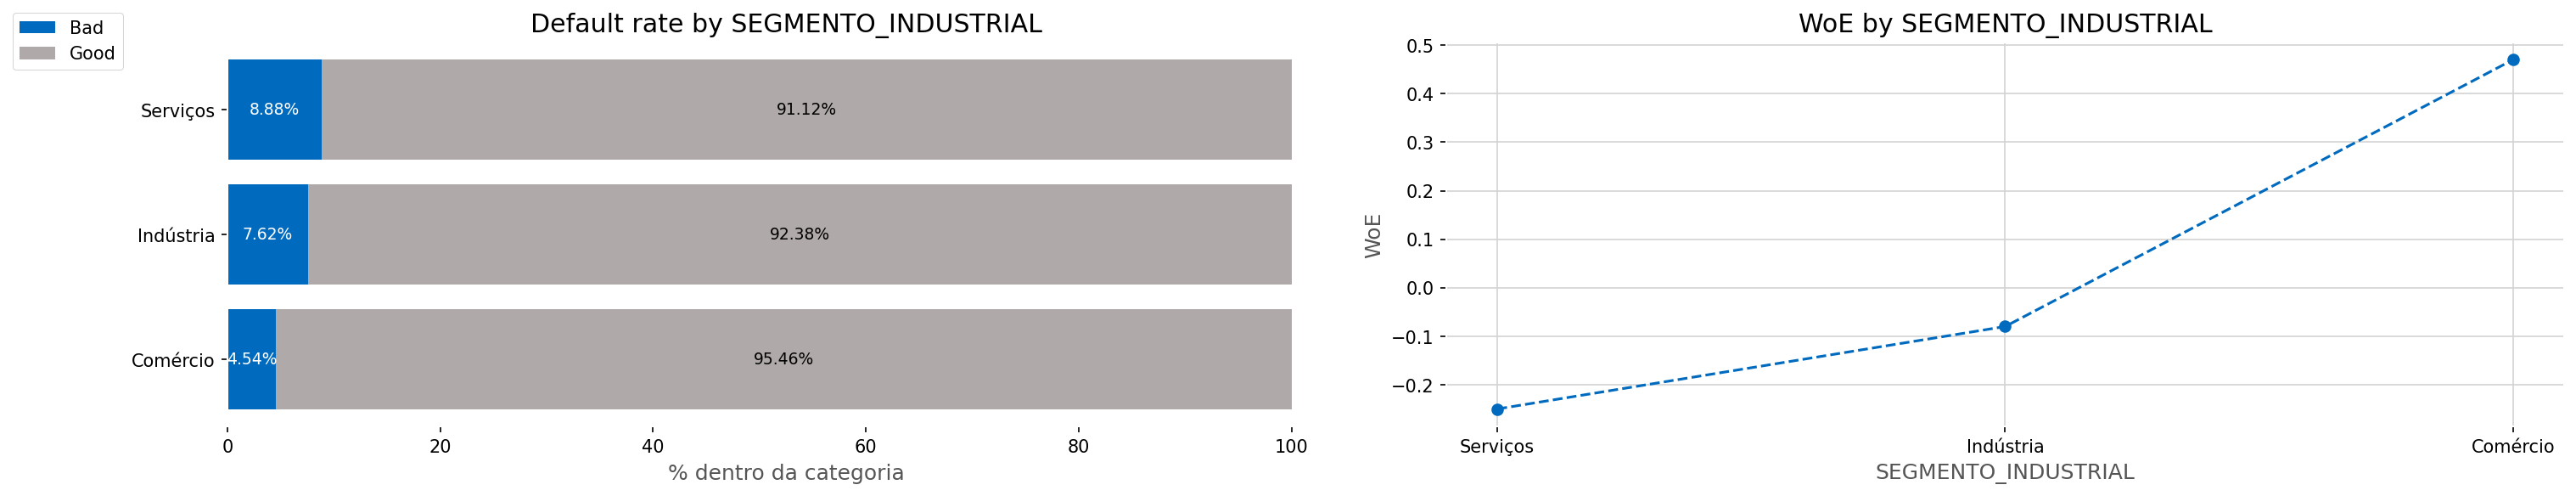

In [433]:
DataUtils.plot_default_woe(
    data=final_train,
    feature='SEGMENTO_INDUSTRIAL',
    target='INADIMPLENTE',
    palette=instyle_palette,
    figsize=(20, 4)
)

- Podemos observa que:
    1. Comércio é o segmento mais seguro, com inadimplência bem abaixo da média.
    2. Indústria e Serviços apresentam níveis de inadimplência semelhantes e mais altos.
    3. O WoE reforça a separação: Comércio é positivo e distanciado, indicando menor risco.
    4. O IV é baixo, então a variável não tem grande poder preditivo isoladamente, mas ainda agrega informação útil ao modelo.

**CEP**

In [434]:
final_train_copy = final_train.copy()

cep_df = DataUtils.woe_iv_table(
    data=final_train_copy,
    feature='REGIAO_CEP',
    target='INADIMPLENTE',
    bad_value=1,
    bins=None
)

cep_df


,n_obs,obs_proportion (%),good_row (%),bad_row (%),n_good,n_bad,good_col (%),bad_col (%),g/b,woe,iv
1,11631.00,16.07,92.86,7.14,10801.00,830.00,16.06,16.29,0.99,-0.01,0.00
2,7373.00,10.19,94.24,5.76,6948.00,425.00,10.33,8.34,1.24,0.21,0.00
3,11018.00,15.23,94.44,5.56,10405.00,613.00,15.47,12.03,1.29,0.25,0.01
4,5625.00,7.77,90.77,9.23,5106.00,519.00,7.59,10.19,0.75,-0.29,0.01
5,3084.00,4.26,88.33,11.67,2724.00,360.00,4.05,7.07,0.57,-0.56,0.02
6,7907.00,10.93,88.74,11.26,7017.00,890.00,10.43,17.47,0.60,-0.52,0.04
7,7824.00,10.81,88.77,11.23,6945.00,879.00,10.32,17.26,0.60,-0.51,0.04
8,11944.00,16.51,97.00,3.00,11586.00,358.00,17.22,7.03,2.45,0.90,0.09
9,5957.00,8.23,96.31,3.69,5737.00,220.00,8.53,4.32,1.97,0.68,0.03
total,72363.00,100.00,92.96,7.04,67269.00,5094.00,100.00,100.00,NaN,NaN,0.23


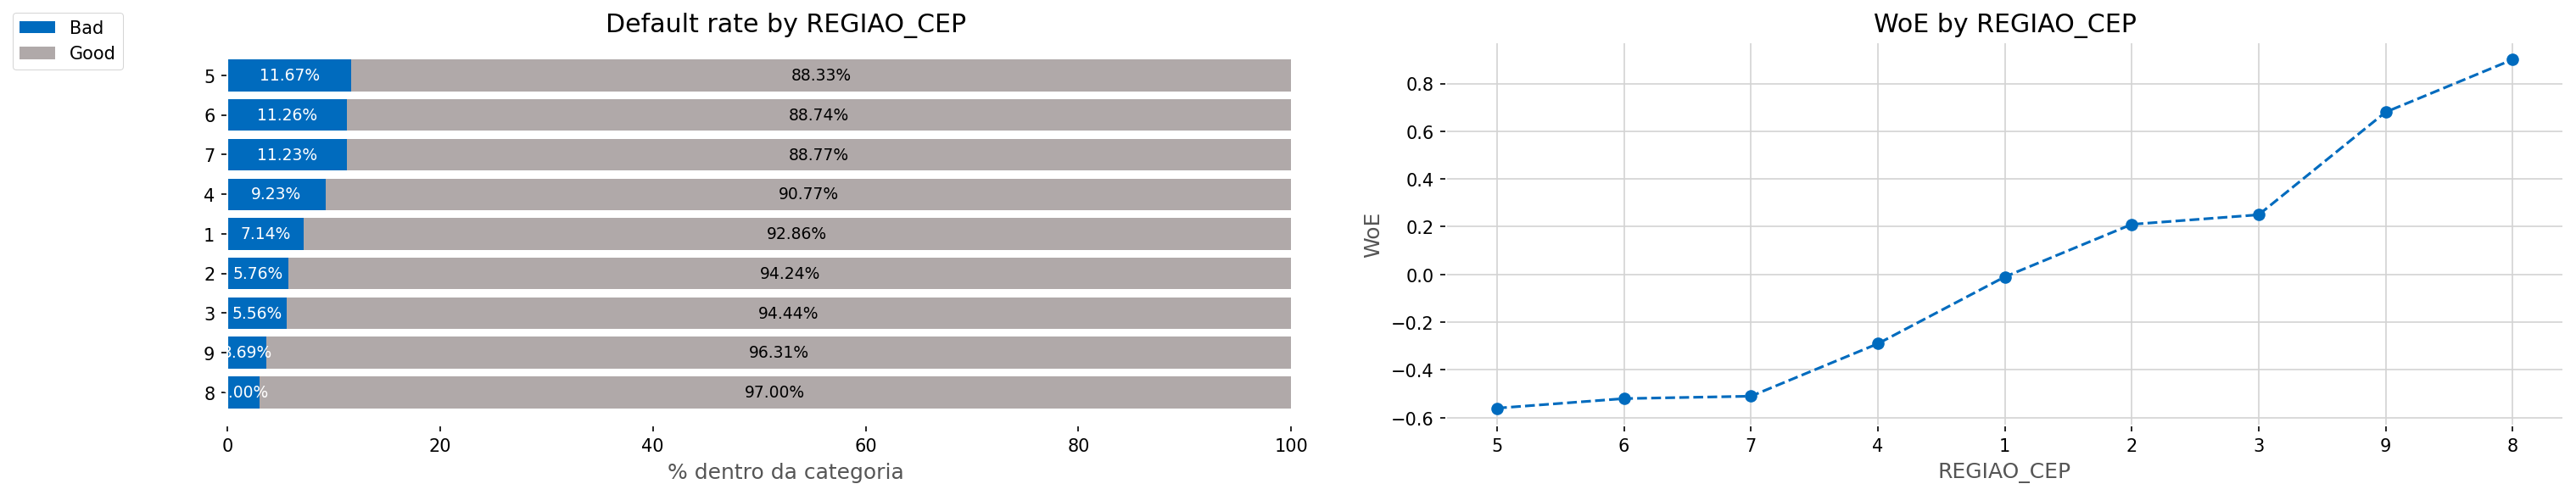

In [435]:
DataUtils.plot_default_woe(
    data=final_train,
    feature='REGIAO_CEP',
    target='INADIMPLENTE',
    palette=instyle_palette,
    figsize=(20, 4)
)

- Podemos observar que:
    1. Existe clara separação entre regiões com maior e menor inadimplência.
    3. A região 4, 5, 6 (estados do Norte e Nordeste) deve ser tratada como ponto de atenção (alta inadimplência).
    4. A região 8 (estados da região Sul) é extremamente segura e pode puxar o score para cima.
    5. O IV moderado indica que essa variável contribui significativamente na explicação do risco.

**DDD**

In [436]:
ddd =  DataUtils.woe_iv_table(
    data=final_train_copy,
    feature='REGIAO_DDD',
    target='INADIMPLENTE',
    bad_value=1,
    bins=None
)

ddd

,n_obs,obs_proportion (%),good_row (%),bad_row (%),n_good,n_bad,good_col (%),bad_col (%),g/b,woe,iv
0,32.00,0.05,65.62,34.38,21.00,11.00,0.04,0.25,0.14,-1.94,0.00
1,17401.00,27.28,94.26,5.74,16402.00,999.00,27.66,22.28,1.24,0.22,0.01
2,5735.00,8.99,92.22,7.78,5289.00,446.00,8.92,9.95,0.90,-0.11,0.00
3,7886.00,12.36,94.51,5.49,7453.00,433.00,12.57,9.66,1.30,0.26,0.01
4,9955.00,15.61,95.76,4.24,9533.00,422.00,16.08,9.41,1.71,0.54,0.04
5,3384.00,5.31,95.80,4.20,3242.00,142.00,5.47,3.17,1.73,0.55,0.01
6,7585.00,11.89,88.86,11.14,6740.00,845.00,11.37,18.84,0.60,-0.51,0.04
7,4016.00,6.30,92.13,7.87,3700.00,316.00,6.24,7.05,0.89,-0.12,0.00
8,4107.00,6.44,89.21,10.79,3664.00,443.00,6.18,9.88,0.63,-0.47,0.02
9,3682.00,5.77,88.40,11.60,3255.00,427.00,5.49,9.52,0.58,-0.55,0.02


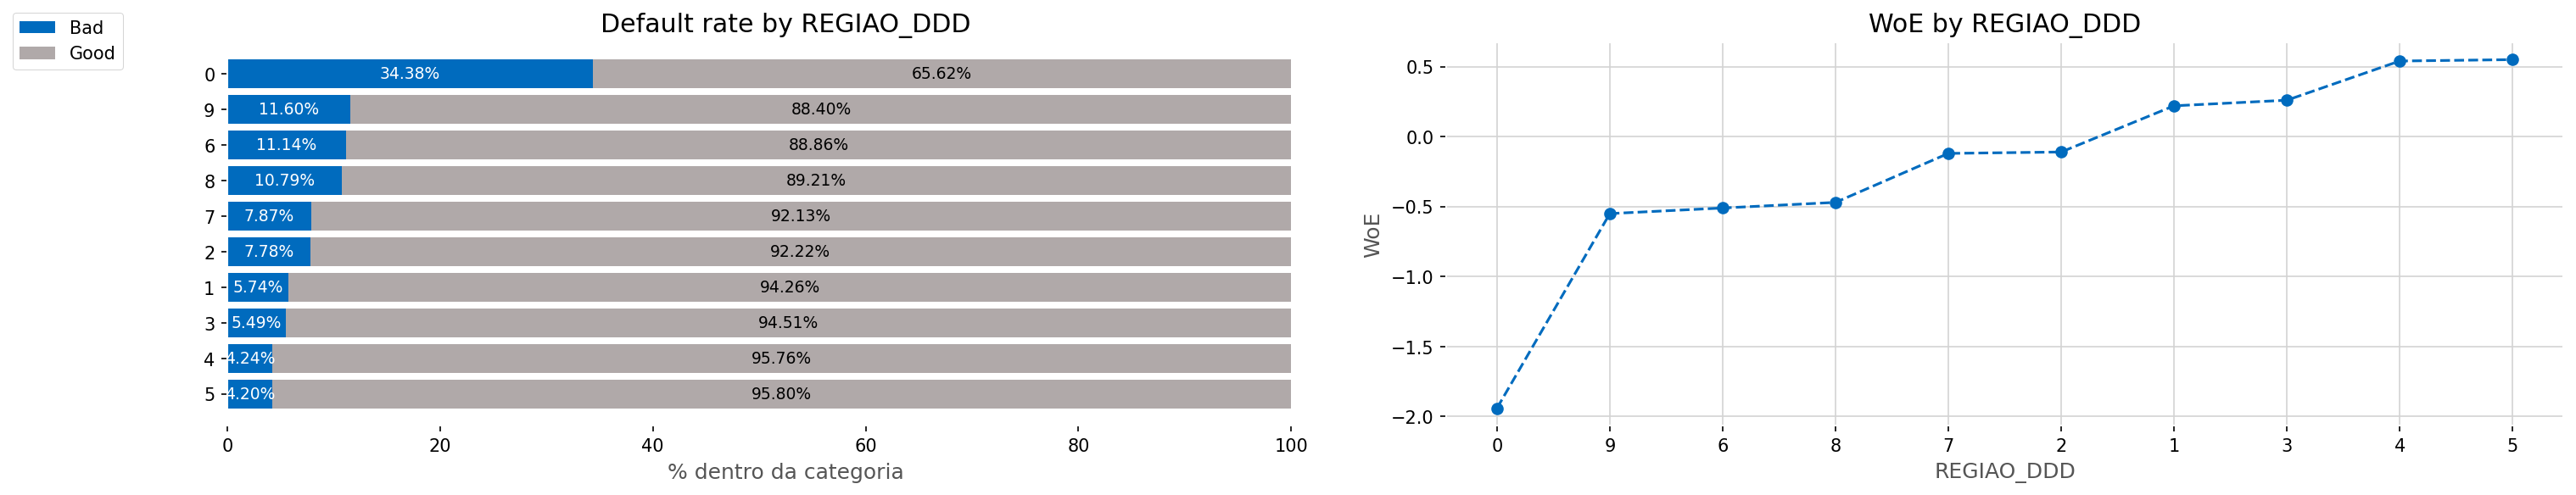

In [437]:
DataUtils.plot_default_woe(
    data=final_train,
    feature='REGIAO_DDD',
    target='INADIMPLENTE',
    palette=instyle_palette,
    figsize=(20, 4)
)

- Podemos observar que:
    1. DDD é um forte discriminador de risco.
    2. Há regiões que concentram inadimplência (ex.: DDD 0, 7, 9).
    3. Outras são muito mais seguras (ex.: DDD 4, 1, 5).
    5. O IV mostra que a variável agrega valor real na predição.

**FLAG_PF**

In [438]:
flag_pf =  DataUtils.woe_iv_table(
    data=final_train_copy,
    feature='FLAG_PF',
    target='INADIMPLENTE',
    bad_value=1,
    bins=None
)

flag_pf

,n_obs,obs_proportion (%),good_row (%),bad_row (%),n_good,n_bad,good_col (%),bad_col (%),g/b,woe,iv
NÃO,72163.00,99.71,92.99,7.01,67101.00,5062.00,99.75,99.25,1.00,0.00,0.00
SIM,207.00,0.29,81.64,18.36,169.00,38.00,0.25,0.75,0.34,-1.09,0.01
total,72370.00,100.00,92.95,7.05,67270.00,5100.00,100.00,100.00,NaN,NaN,0.01


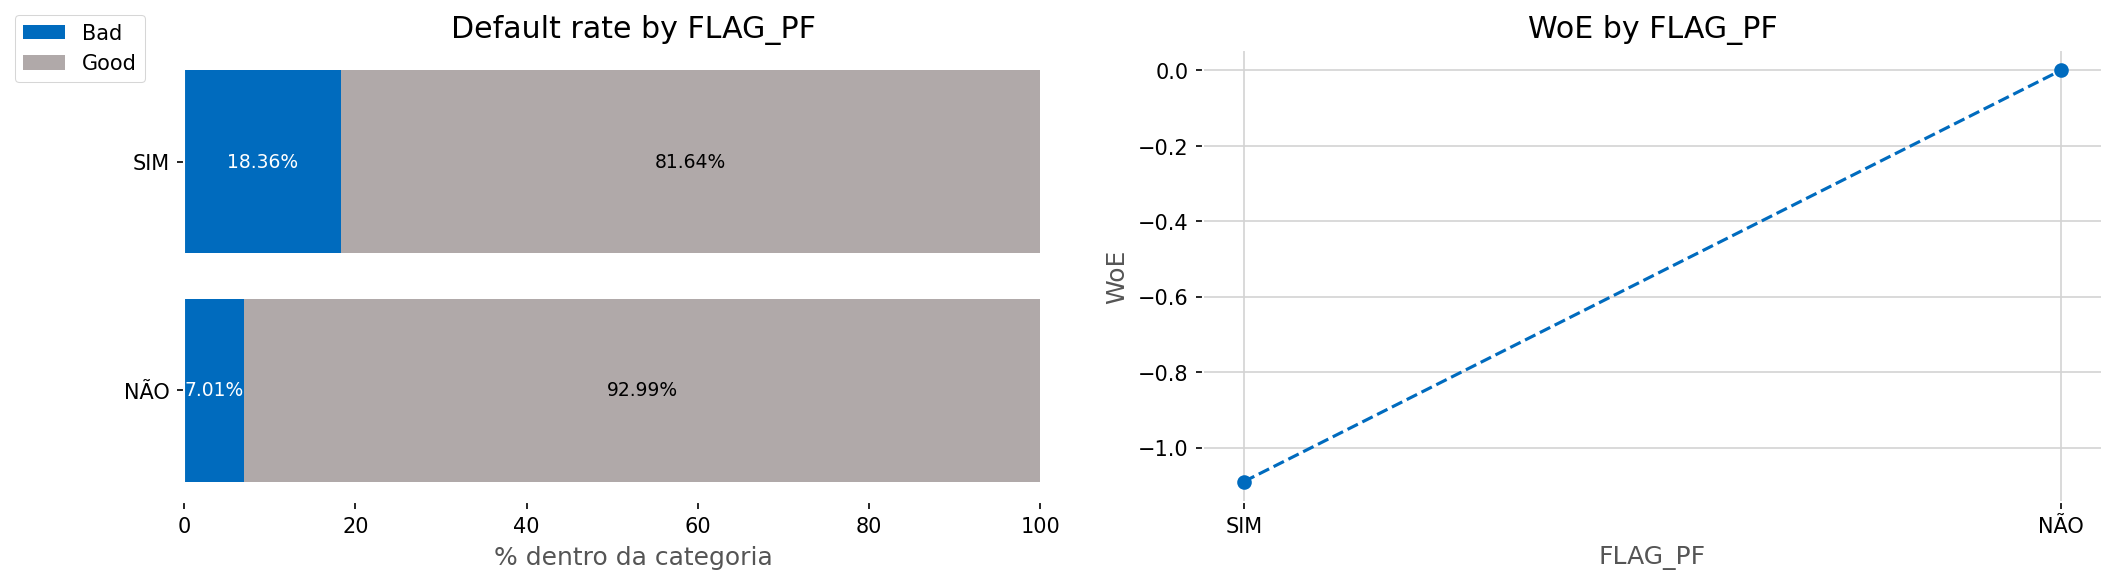

In [439]:
DataUtils.plot_default_woe(
    data=final_train,
    feature='FLAG_PF',
    target='INADIMPLENTE',
    palette=instyle_palette
)

- Podemos observar que:
    1. Clientes pessoa física apresentam uma taxa de inadimplência significativamente superior (17,32% vs. 7,41% em PJ).
    2. No entanto, por representarem apenas 0,29% da base, o que se reflete em seu Information Value igual a zero.
    3. Assim, FLAG_PF denota que PFs são um grupo naturalmente mais arriscado. Entretanto, possuem poucos casos na base.

**PORTE**

In [440]:
porte =  DataUtils.woe_iv_table(
    data=final_train_copy,
    feature='PORTE',
    target='INADIMPLENTE',
    bad_value=1,
    bins=None
)

porte

,n_obs,obs_proportion (%),good_row (%),bad_row (%),n_good,n_bad,good_col (%),bad_col (%),g/b,woe,iv
GRANDE,27092.00,38.67,94.57,5.43,25621.00,1471.00,39.19,31.38,1.25,0.22,0.02
MEDIO,27958.00,39.91,93.56,6.44,26157.00,1801.00,40.01,38.42,1.04,0.04,0.00
PEQUENO,15010.00,21.42,90.57,9.43,13594.00,1416.00,20.79,30.20,0.69,-0.37,0.04
total,70060.00,100.00,93.31,6.69,65372.00,4688.00,100.00,100.00,NaN,NaN,0.05


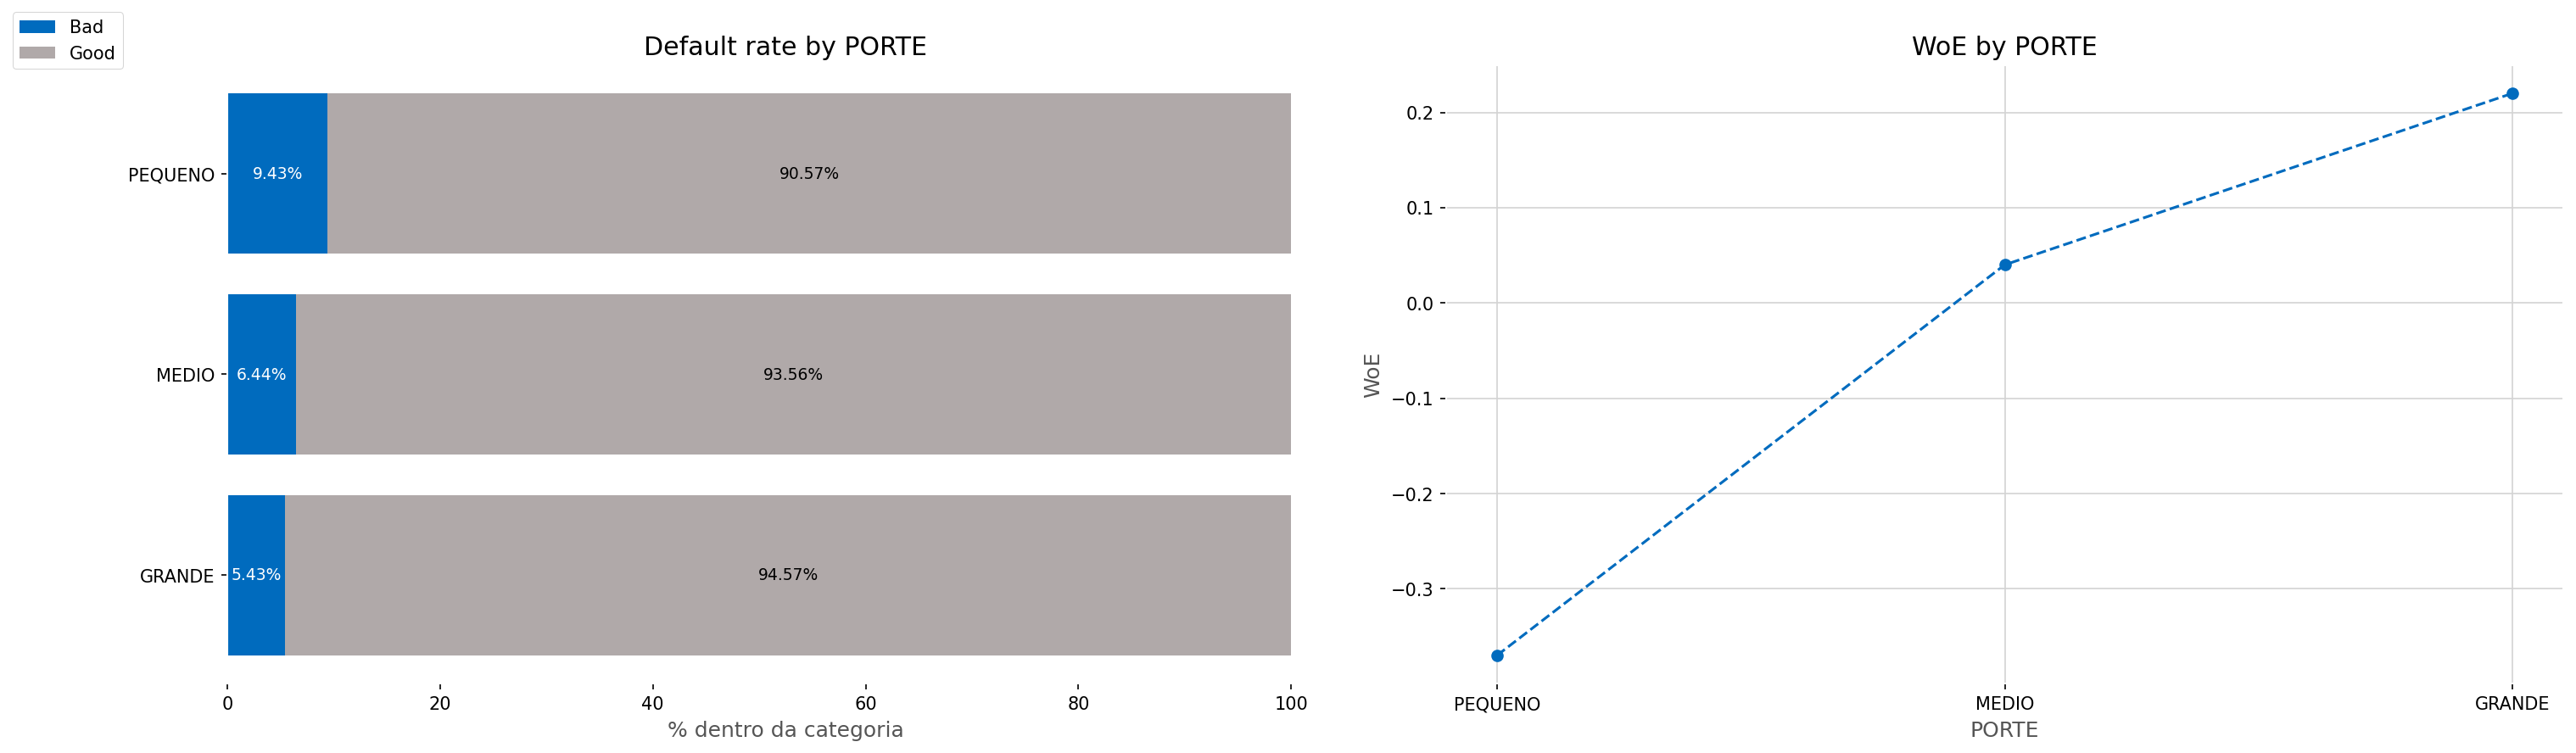

In [441]:
DataUtils.plot_default_woe(
    data=final_train,
    feature='PORTE',
    target='INADIMPLENTE',
    palette=instyle_palette
    ,figsize=(20, 6)
)

A inadimplência apresenta relação inversa com o porte da empresa. Empresas de menor porte exibem taxa de inadimplência significativamente maior (10,58%), enquanto empresas grandes demonstram comportamento substancialmente mais seguro (4,97%). A variável apresenta WoE monotônico e IV = 0,10, indicando bom poder discriminatório e relevância para o modelo de crédito.

**DOMINIO**



In [442]:
dominio =  DataUtils.woe_iv_table(
    data=final_train_copy,
    feature='DOMINIO_EMAIL',
    target='INADIMPLENTE',
    bad_value=1,
    bins=None
)

dominio

,n_obs,obs_proportion (%),good_row (%),bad_row (%),n_good,n_bad,good_col (%),bad_col (%),g/b,woe,iv
AOL,4152.00,5.80,95.93,4.07,3983.00,169.00,5.99,3.35,1.79,0.58,0.02
BOL,1726.00,2.41,92.53,7.47,1597.00,129.00,2.40,2.56,0.94,-0.06,0.00
GMAIL,19897.00,27.81,92.79,7.21,18463.00,1434.00,27.77,28.41,0.98,-0.02,0.00
HOTMAIL,17599.00,24.60,90.69,9.31,15961.00,1638.00,24.01,32.45,0.74,-0.30,0.03
OUTLOOK,4518.00,6.32,94.69,5.31,4278.00,240.00,6.43,4.76,1.35,0.30,0.01
YAHOO,23645.00,33.05,93.92,6.08,22208.00,1437.00,33.40,28.47,1.17,0.16,0.01
total,71537.00,100.00,92.94,7.06,66490.00,5047.00,100.00,100.00,NaN,NaN,0.05


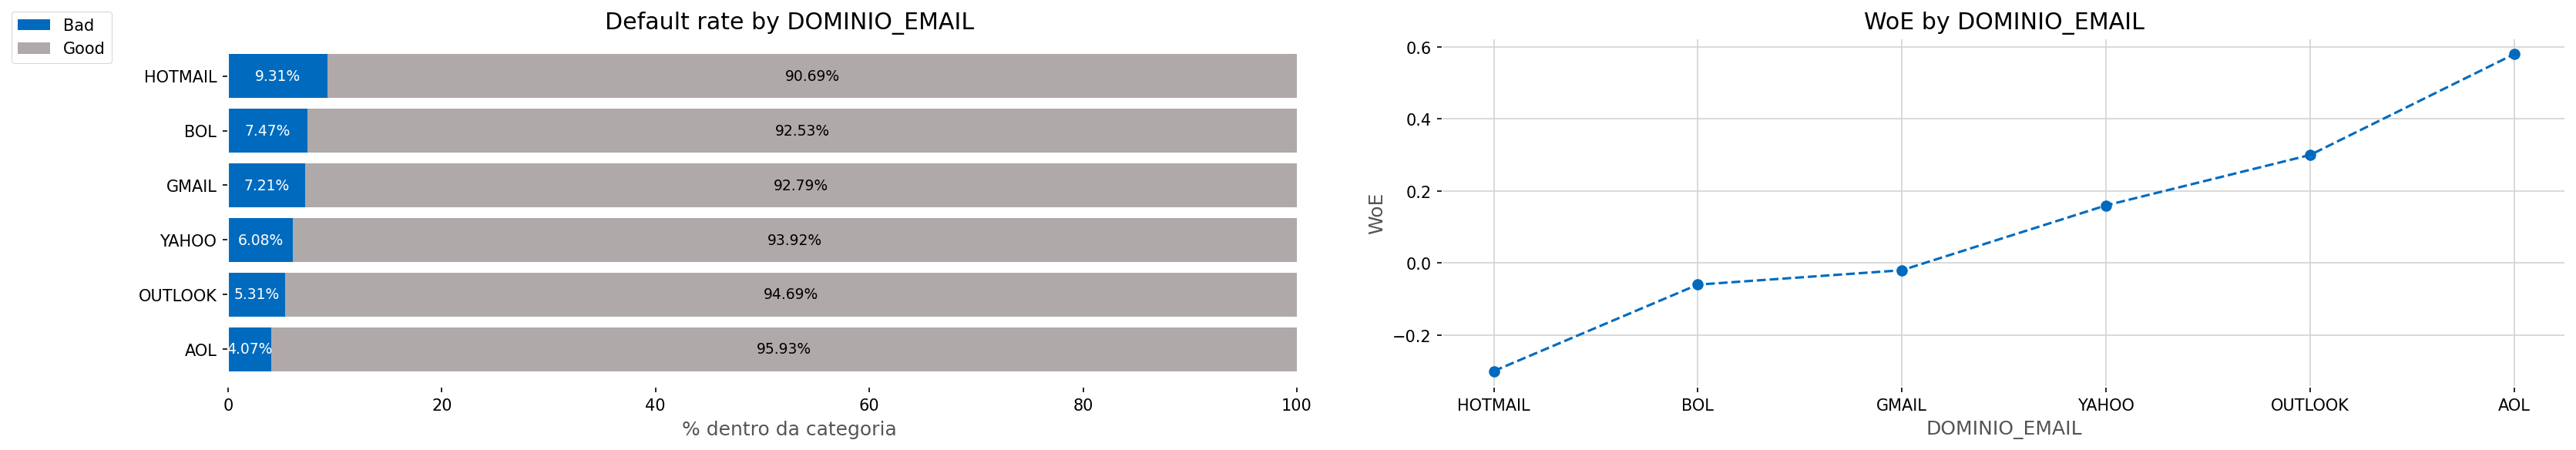

In [443]:
DataUtils.plot_default_woe(
    data=final_train,
    feature='DOMINIO_EMAIL',
    target='INADIMPLENTE',
    palette=instyle_palette,
    figsize=(22, 4)
)

A variável DOMINIO_EMAIL apresenta diferenças moderadas entre categorias, com domínios como BOL exibindo taxas de inadimplência superiores (9,23%) e domínios como AOL apresentando melhor desempenho (4,79%). Apesar disso, o Information Value é baixo (IV ≈ 0,02), indicando fraca capacidade discriminatória. Assim, embora exista alguma correlação com o risco, a variável deve ser tratada como auxiliar, com impacto limitado na performance geral do modelo.

### **Conclusões**

A análise exploratória permitiu consolidar os principais pontos abaixo:

- **Construção do target e recorte temporal**
  - O target foi definido corretamente como atraso **≥ 5 dias** entre DATA_PAGAMENTO e DATA_VENCIMENTO.
  - A separação em treino/validação seguiu um **OOT split temporal por SAFRA_REF**, garantindo avaliação mais realista da capacidade de generalização do modelo.
  - As taxas de inadimplência entre treino e validação são semelhantes, indicando que o split está bem calibrado.

- **Base de pagamentos**
  - Há concentração relevante em poucas faixas de taxa de juros (principalmente 4,99%, 5,99% e 6,99%), com distribuição de valor a pagar assimétrica e presença de outliers.
  - A inadimplência varia ao longo do tempo, com períodos de maior risco que serão capturados por variáveis temporais na modelagem.
  - O comportamento por cliente mostra que alguns têm grande volume de transações e valores elevados, o que reforça a importância de features agregadas por histórico.

- **Base cadastral**
  - A carteira é majoritariamente composta por **pessoa jurídica**, com concentração relevante em determinadas regiões (DDD e CEP, especialmente região 1 / SP).
  - Variáveis de **porte** e **segmento industrial** apresentam relação clara com o risco: empresas maiores e segmentos mais estruturados tendem a inadimplir menos.
  - Essas variáveis cadastrais se mostram boas candidatas a features importantes de perfil.

- **Base info**
  - RENDA_MES_ANTERIOR e NO_FUNCIONARIOS apresentam caudas longas e outliers, mas coerentes com a realidade de clientes heterogêneos em porte e faturamento.
  - A proporção de valores ausentes por cliente é baixa, e a estratégia de preenchimento temporal (ffill) preserva a consistência da série no tempo.
  - Essas variáveis reforçam o poder de discriminação entre clientes mais robustos e mais frágeis financeiramente.

- **Análise multivariada e relação com o risco**
  - As correlações lineares entre variáveis numéricas são, em geral, baixas, reduzindo preocupação com multicolinearidade severa.
  - Medidas de IV/WoE indicam que **DDD, CEP, PORTE, SEGMENTO, FLAG_PF e algumas taxas** possuem boa capacidade discriminante.
  - De forma geral, o risco se mostra influenciado por três blocos principais: **características temporais, geográficas e de perfil/capacidade financeira**.
